In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy
import datetime
import pandas as pd
import time
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from os import path
from gensim.models import CoherenceModel
from gensim.models import ldaseqmodel
from pprint import pprint

In [98]:
my_df = pd.read_pickle("./tweets_per_weeks.pkl")

In [99]:
len(my_df)

42976

# Collect tweets

In [81]:
from_date = datetime.date(2019,3,31)
to_date = datetime.date(2020,4,1)

In [450]:
datelist = pd.date_range(from_date, to_date, freq='2w').tolist()

In [250]:
datelist = pd.date_range(from_date, to_date, freq='2w').tolist()
#data= dict()
#col_names =  ['weeks', 'date', 'tweet']
#my_df  = pd.DataFrame(columns = col_names)
for i in range(0,26) :
    if i in [5,10,15]:
        time.sleep(5)
    text_query = 'Insurance Canada'
    since_date = str(datelist[i].date())
    until_date = str(datelist[i+1].date())
    #count = 1000
    #Creation of query object
    tweetCriteria = manager.TweetCriteria().setQuerySearch(text_query).setSince(since_date).setUntil(until_date)#.setMaxTweets(count)
    # Creation of list that contains all tweets.
    tweets = manager.TweetManager.getTweets(tweetCriteria)
    for tweet in tweets : 
        my_df.loc[len(my_df)] = ["weeks_"+str(i+1), tweet.date.date(), tweet.text]
#      # Creating list of chosen tweet data
#     #text_tweets = [[tweet.date, tweet.text] for tweet in tweets]
#     my_df.loc[len(my_df)] = ["weeks_"+str(i+1), tweet.date, tweet.text] for tweet in tweets]

#     print("weeks_"+str(i+1))
#     #data["weeks_"+str(i+1)] = [tweet.text for tweet in tweets]

my_df.to_pickle("./tweets_per_weeks.pkl")


# preprocessing

In [31]:
data = my_df.tweet.values.tolist()


In [32]:
data

['Canada just stick to hockey...and free health insurance',
 'Yep—it’s talking about care, not insurance. It also notes that Canada is seeing similar problems, despite being SP. Oh, and it’s from 2004, 10 years before implementation of ACA.',
 "I'd go to a life insurance broker who deals w at least 3 life insurance companies in Canada. As for the RESP, how old is your kid? how much investment experience do you have? ",
 'As a chronic pain patient who has had to give up one of my most important meds because of cost ($700/mo w/insurance vs $200/mo w/o insurance in Canada) I am reminded every day that my pain is caused by the refusal to rein in pharmaceutical companies. Business first.Patients last. ',
 'So to recap, @TorontoPearson security for a CONNECTION took over an hour and a half. We missed our @AirCanada flight by minutes, and Air Canada is like ¯\\_(ツ)_/¯, have a broken link that should tell you about travel insurance',
 'True story, talk to a 60ish man on beach in Maui. Had hear

In [26]:
#Emoji patterns
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [27]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',"¯\_" ,"ツ", "_/¯",
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
#combine sad and happy emoticons
emoticons = emoticons_happy.union(emoticons_sad)

In [28]:
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod ):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def preprocess_tweets(tweets ):
    # convert text to lower-case
    tweets = [tweet.lower() for tweet in tweets]
    
    # remove URLs
    tweets = [re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', tweet) for tweet in tweets]
    tweets = [re.sub(r'http\S+', '', tweet) for tweet in tweets]

    # remove emojis from tweet
    tweets = [emoji_pattern.sub(r'', tweet) for tweet in tweets]
    
    # Remove non-alphabet
    tweets = [re.sub(r'[^a-zA-Z]|(\w+:\/\/\S+)',' ', tweet) for tweet in tweets]
 
    # tokenization
    tweets_word_tokens = [word_tokenize(tweet) for tweet in tweets]
    
    # Remove short words (length < 3)
    tweets_word_tokens = [[w for w in tweet_word_tokens if len(w)>2] for tweet_word_tokens in tweets_word_tokens]
    
    # remove stopwords
    additional_stop_words=['j']
    stop_words = set(stopwords.words('english')).union(additional_stop_words)
    tweets_word_tokens_nostops = [[word for word in tweet if ( word not in stop_words and word not in emoticons and word not in string.punctuation)] for tweet in tweets_word_tokens]

       # Unigram
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(tweets_word_tokens, min_count=5, threshold=100)  # higher threshold fewer phrases.

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    # form bigram
    tweets_tokens_bigrams = make_bigrams(tweets_word_tokens_nostops, bigram_mod )
    
    return tweets_tokens_bigrams



In [214]:

#preprocess
data_clean = preprocess_tweets(data) 

# Create Dictionary
id2word = corpora.Dictionary(data_clean)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_clean]


In [1]:
my_df_clean=pd.read_pickle("./clean_tweets_per_weeks.pkl")

<IPython.core.display.Javascript object>

In [2]:
data_clean = my_df_clean.tweet

# LDA

In [100]:
dict_dur = {}
# LDA models
for i in range(24,102,2):
        start = time.time()
        lda_model = LdaMulticore(corpus,id2word=id2word, num_topics=i,passes=50, iterations =1000, workers = 3)
        end = time.time()
        dict_dur[str(i)+'topic'] = end-start
        lda_model.save(path.join('output','tweets_Lda_model_' + str(i) + "_topics"))
        del lda_model
        ps=pd.DataFrame([dict_dur])
        ps.to_pickle("./dict_dur.pkl")



In [212]:
lda_models=[]
for i in range(2,102,2):
    lda_models.append(gensim.models.LdaModel.load("output/tweets_Lda_model_"+str(i)+"_topics"))

In [81]:
len(lda_models)

50

In [36]:

pprint(lda_models[2].print_topics())

[(0,
  '0.058*"insurance" + 0.052*"canada" + 0.015*"get" + 0.007*"one" + '
  '0.007*"back" + 0.007*"got" + 0.006*"cost" + 0.006*"insulin" + 0.006*"month" '
  '+ 0.005*"year"'),
 (1,
  '0.071*"insurance" + 0.060*"canada" + 0.010*"business" + 0.009*"life" + '
  '0.006*"company" + 0.006*"new" + 0.005*"employment" + 0.005*"one" + '
  '0.004*"amp" + 0.004*"toronto"'),
 (2,
  '0.063*"canada" + 0.063*"insurance" + 0.040*"travel" + 0.021*"employment" + '
  '0.015*"health" + 0.014*"ontario" + 0.014*"medical" + 0.013*"covid" + '
  '0.012*"coverage" + 0.009*"get"'),
 (3,
  '0.059*"insurance" + 0.054*"canada" + 0.025*"health" + 0.024*"private" + '
  '0.015*"care" + 0.014*"healthcare" + 0.012*"like" + 0.012*"pay" + '
  '0.011*"system" + 0.011*"people"'),
 (4,
  '0.050*"insurance" + 0.047*"canada" + 0.014*"social" + 0.013*"number" + '
  '0.010*"service" + 0.007*"home" + 0.006*"covid" + 0.006*"loss" + 0.006*"amp" '
  '+ 0.005*"call"'),
 (5,
  '0.046*"canada" + 0.042*"insurance" + 0.027*"health" + 0.0

In [216]:
Perplexity=[]
Coherence=[]
for i in range(50):
    # Compute Perplexity
    Perplexity.append(lda_models[i].log_perplexity(corpus))  # a measure of how good the model is. lower the better.
    # Compute coherence
    Coherence.append(CoherenceModel(model=lda_models[i], texts=data_clean, dictionary=id2word, coherence='c_v').get_coherence())

In [221]:

pd.DataFrame(Perplexity).to_pickle("./Perplexity.pkl")

pd.DataFrame(Coherence).to_pickle("./Coherence.pkl")


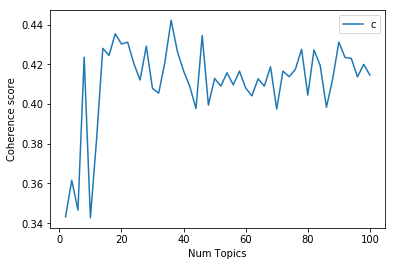

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
# Show graph
limit=102; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, Coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()




In [53]:
lda_models[17].num_topics

36

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

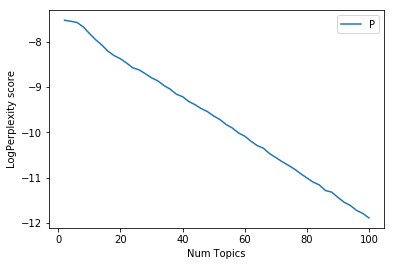

In [220]:
limit=102; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, Perplexity)
plt.xlabel("Num Topics")
plt.ylabel("LogPerplexity score")
plt.legend(("Perplexity_values"), loc='best')
plt.show()

# Dynamic LDA // k = 36

In [54]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [78]:
time_slice=list(numpy.asarray(my_df['weeks'].value_counts()[my_df['weeks'].unique()]))


In [116]:
ldaseq

In [110]:
start_ldaseq = time.time()
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=id2word, time_slice=time_slice, num_topics=36, chunksize=1, chain_variance=0.05)
end_ldaseq = time.time()
dur_ldaseq =end_ldaseq-start_ldaseq


2020-04-16 00:35:15,578 : INFO : using symmetric eta at 0.027777777777777776
2020-04-16 00:35:15,588 : INFO : using serial LDA version on this node
2020-04-16 00:35:15,746 : INFO : running online (multi-pass) LDA training, 36 topics, 10 passes over the supplied corpus of 42976 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-16 00:35:15,747 : INFO : PROGRESS: pass 0, at document #2000/42976
2020-04-16 00:35:16,799 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:16,870 : INFO : topic #25 (0.010): 0.029*"insurance" + 0.027*"care" + 0.024*"health" + 0.021*"canada" + 0.019*"healthcare" + 0.012*"free" + 0.011*"work" + 0.010*"good" + 0.010*"like" + 0.009*"medicare"
2020-04-16 00:35:16,872 : INFO : topic #4 (0.010): 0.055*"canada" + 0.053*"insurance" + 0.020*"health" + 0.010*"pay" + 0.009*"private" + 0.009*"cost" + 0.008*"travel" + 0.007

2020-04-16 00:35:20,743 : INFO : topic #24 (0.010): 0.064*"insurance" + 0.055*"canada" + 0.014*"get" + 0.012*"job" + 0.010*"quebec" + 0.010*"son" + 0.010*"live" + 0.009*"people" + 0.009*"school" + 0.008*"coming"
2020-04-16 00:35:20,748 : INFO : topic diff=0.094728, rho=0.408248
2020-04-16 00:35:20,753 : INFO : PROGRESS: pass 0, at document #14000/42976
2020-04-16 00:35:21,356 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:21,417 : INFO : topic #21 (0.010): 0.060*"insurance" + 0.052*"canada" + 0.033*"private" + 0.020*"connected" + 0.015*"nhs" + 0.014*"provider" + 0.013*"hear" + 0.013*"guess" + 0.012*"present" + 0.012*"medicare"
2020-04-16 00:35:21,418 : INFO : topic #11 (0.010): 0.068*"insurance" + 0.060*"canada" + 0.024*"numbers" + 0.020*"canadian" + 0.019*"existing" + 0.018*"bank" + 0.017*"line" + 0.016*"social" + 0.016*"policies" + 0.014*"drive"
2020-04-16 00:35:21,420 : INFO : topic #2 (0.010): 0.068*"insurance" + 0.063*"canada" + 0.035

2020-04-16 00:35:25,648 : INFO : topic #29 (0.010): 0.067*"insurance" + 0.065*"canada" + 0.032*"health" + 0.027*"get" + 0.019*"medical" + 0.019*"care" + 0.018*"even" + 0.015*"need" + 0.012*"doctor" + 0.012*"doctors"
2020-04-16 00:35:25,653 : INFO : topic diff=0.067848, rho=0.288675
2020-04-16 00:35:25,660 : INFO : PROGRESS: pass 0, at document #26000/42976
2020-04-16 00:35:26,217 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:26,277 : INFO : topic #16 (0.010): 0.053*"insurance" + 0.052*"canada" + 0.026*"paid" + 0.022*"weeks" + 0.018*"needed" + 0.017*"yes" + 0.017*"part" + 0.013*"research" + 0.013*"went" + 0.013*"fees"
2020-04-16 00:35:26,279 : INFO : topic #30 (0.010): 0.041*"canada" + 0.041*"options" + 0.039*"insurance" + 0.038*"learn" + 0.030*"experience" + 0.016*"york" + 0.015*"clear" + 0.015*"definitely" + 0.014*"finance" + 0.014*"management"
2020-04-16 00:35:26,281 : INFO : topic #1 (0.010): 0.085*"insurance" + 0.069*"canada" + 0.027*

2020-04-16 00:35:29,559 : INFO : topic diff=0.056340, rho=0.235702
2020-04-16 00:35:29,565 : INFO : PROGRESS: pass 0, at document #38000/42976
2020-04-16 00:35:30,144 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:30,203 : INFO : topic #0 (0.010): 0.058*"insurance" + 0.053*"canada" + 0.021*"shit" + 0.018*"least" + 0.017*"mortgage" + 0.015*"guys" + 0.014*"almost" + 0.013*"info" + 0.013*"ridiculous" + 0.012*"take"
2020-04-16 00:35:30,205 : INFO : topic #5 (0.010): 0.086*"insurance" + 0.073*"canada" + 0.032*"auto" + 0.026*"rates" + 0.024*"premiums" + 0.018*"bureau" + 0.017*"costs" + 0.013*"highest" + 0.011*"workers" + 0.010*"big_pharma"
2020-04-16 00:35:30,207 : INFO : topic #8 (0.010): 0.072*"canada" + 0.070*"insurance" + 0.029*"employment" + 0.022*"government" + 0.022*"get" + 0.020*"choice" + 0.017*"without" + 0.017*"lol" + 0.015*"leave" + 0.015*"federal"
2020-04-16 00:35:30,209 : INFO : topic #25 (0.010): 0.099*"pay" + 0.095*"free" + 0.079

2020-04-16 00:35:34,440 : INFO : topic #10 (0.010): 0.067*"insurance" + 0.067*"canada" + 0.040*"wait" + 0.034*"time" + 0.031*"months" + 0.024*"get" + 0.020*"long" + 0.019*"paying" + 0.015*"see" + 0.015*"pay"
2020-04-16 00:35:34,445 : INFO : topic diff=0.050315, rho=0.206337
2020-04-16 00:35:34,450 : INFO : PROGRESS: pass 1, at document #6000/42976
2020-04-16 00:35:35,034 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:35,102 : INFO : topic #33 (0.010): 0.062*"canada" + 0.061*"insurance" + 0.026*"years" + 0.023*"back" + 0.022*"got" + 0.017*"would" + 0.016*"never" + 0.014*"lived" + 0.012*"really" + 0.012*"get"
2020-04-16 00:35:35,105 : INFO : topic #28 (0.010): 0.056*"insurance" + 0.054*"canada" + 0.019*"money" + 0.018*"world" + 0.017*"companies" + 0.017*"making" + 0.015*"sick" + 0.015*"people" + 0.014*"poor" + 0.014*"make"
2020-04-16 00:35:35,107 : INFO : topic #6 (0.010): 0.072*"insurance" + 0.060*"canada" + 0.040*"bill" + 0.036*"ask" + 0.0

2020-04-16 00:35:38,397 : INFO : topic diff=0.036241, rho=0.206337
2020-04-16 00:35:38,402 : INFO : PROGRESS: pass 1, at document #18000/42976
2020-04-16 00:35:38,886 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:38,949 : INFO : topic #0 (0.010): 0.053*"insurance" + 0.049*"canada" + 0.025*"least" + 0.022*"mortgage" + 0.018*"almost" + 0.017*"info" + 0.016*"payment" + 0.015*"guys" + 0.015*"shit" + 0.012*"given"
2020-04-16 00:35:38,950 : INFO : topic #18 (0.010): 0.101*"insurance" + 0.092*"canada" + 0.065*"company" + 0.059*"life" + 0.039*"group" + 0.034*"service" + 0.028*"team" + 0.025*"looking" + 0.023*"join" + 0.019*"financial"
2020-04-16 00:35:38,952 : INFO : topic #16 (0.010): 0.041*"canada" + 0.041*"insurance" + 0.033*"weeks" + 0.032*"paid" + 0.027*"needed" + 0.019*"went" + 0.018*"two" + 0.018*"part" + 0.015*"research" + 0.015*"unemployment"
2020-04-16 00:35:38,956 : INFO : topic #2 (0.010): 0.069*"provide" + 0.054*"employee" + 0.036*"i

2020-04-16 00:35:42,865 : INFO : topic diff=0.030645, rho=0.206337
2020-04-16 00:35:42,870 : INFO : PROGRESS: pass 1, at document #30000/42976
2020-04-16 00:35:43,395 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:43,455 : INFO : topic #15 (0.010): 0.059*"tax" + 0.050*"insurance" + 0.045*"canada" + 0.030*"per" + 0.030*"income" + 0.029*"pay" + 0.017*"pays" + 0.016*"month" + 0.013*"pension" + 0.011*"less"
2020-04-16 00:35:43,456 : INFO : topic #4 (0.010): 0.070*"insurance" + 0.068*"canada" + 0.027*"cost" + 0.021*"compare" + 0.019*"pay" + 0.018*"health" + 0.016*"costs" + 0.015*"pocket" + 0.015*"premium" + 0.014*"difference"
2020-04-16 00:35:43,458 : INFO : topic #27 (0.010): 0.032*"insurance" + 0.028*"amp" + 0.026*"protect" + 0.024*"show" + 0.023*"canada" + 0.022*"party" + 0.019*"fraud" + 0.019*"man" + 0.018*"set" + 0.018*"scam"
2020-04-16 00:35:43,460 : INFO : topic #25 (0.010): 0.137*"pay" + 0.109*"free" + 0.073*"taxes" + 0.065*"healthcare"

2020-04-16 00:35:47,399 : INFO : topic diff=0.026182, rho=0.206337
2020-04-16 00:35:47,404 : INFO : PROGRESS: pass 1, at document #42000/42976
2020-04-16 00:35:47,954 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:48,012 : INFO : topic #0 (0.010): 0.043*"insurance" + 0.040*"canada" + 0.032*"least" + 0.027*"mortgage" + 0.026*"shit" + 0.020*"guys" + 0.019*"put" + 0.016*"payment" + 0.016*"almost" + 0.015*"times"
2020-04-16 00:35:48,014 : INFO : topic #30 (0.010): 0.054*"options" + 0.043*"learn" + 0.032*"experience" + 0.030*"pet" + 0.026*"consider" + 0.024*"clear" + 0.021*"finance" + 0.019*"asking" + 0.018*"definitely" + 0.018*"stuck"
2020-04-16 00:35:48,016 : INFO : topic #12 (0.010): 0.082*"apply" + 0.046*"low" + 0.040*"fact" + 0.036*"test" + 0.035*"answer" + 0.034*"especially" + 0.030*"insurance" + 0.029*"sign" + 0.025*"quote" + 0.023*"wanted"
2020-04-16 00:35:48,018 : INFO : topic #13 (0.010): 0.083*"health" + 0.080*"insurance" + 0.075*"ca

2020-04-16 00:35:51,172 : INFO : topic diff=0.025867, rho=0.202080
2020-04-16 00:35:51,179 : INFO : PROGRESS: pass 2, at document #10000/42976
2020-04-16 00:35:51,663 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:51,722 : INFO : topic #22 (0.010): 0.074*"canada" + 0.064*"ontario" + 0.061*"insurance" + 0.058*"coverage" + 0.057*"medical" + 0.045*"health" + 0.030*"dental" + 0.024*"emergency" + 0.024*"plan" + 0.022*"toronto_mississauga"
2020-04-16 00:35:51,724 : INFO : topic #35 (0.010): 0.076*"insurance" + 0.067*"canada" + 0.037*"like" + 0.034*"want" + 0.032*"people" + 0.021*"private" + 0.019*"would" + 0.018*"think" + 0.015*"companies" + 0.012*"healthcare"
2020-04-16 00:35:51,725 : INFO : topic #21 (0.010): 0.040*"different" + 0.036*"nhs" + 0.031*"example" + 0.025*"insurance" + 0.023*"guess" + 0.022*"provider" + 0.021*"canada" + 0.021*"allows" + 0.020*"hear" + 0.019*"planning"
2020-04-16 00:35:51,727 : INFO : topic #28 (0.010): 0.049*"canada

2020-04-16 00:35:55,276 : INFO : topic diff=0.028464, rho=0.202080
2020-04-16 00:35:55,285 : INFO : PROGRESS: pass 2, at document #22000/42976
2020-04-16 00:35:55,824 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:55,902 : INFO : topic #10 (0.010): 0.065*"canada" + 0.065*"insurance" + 0.050*"wait" + 0.038*"time" + 0.037*"months" + 0.029*"get" + 0.027*"long" + 0.025*"see" + 0.020*"visit" + 0.018*"surgery"
2020-04-16 00:35:55,904 : INFO : topic #22 (0.010): 0.072*"canada" + 0.066*"insurance" + 0.065*"ontario" + 0.060*"health" + 0.053*"dental" + 0.051*"medical" + 0.047*"toronto_mississauga" + 0.047*"price_quote" + 0.047*"quote_click" + 0.046*"coverage"
2020-04-16 00:35:55,906 : INFO : topic #6 (0.010): 0.075*"bill" + 0.054*"insurance" + 0.051*"canada" + 0.047*"ask" + 0.030*"major" + 0.027*"left" + 0.025*"trip" + 0.023*"buying" + 0.023*"order" + 0.021*"questions"
2020-04-16 00:35:55,909 : INFO : topic #15 (0.010): 0.055*"tax" + 0.046*"insuranc

2020-04-16 00:35:59,097 : INFO : PROGRESS: pass 2, at document #34000/42976
2020-04-16 00:35:59,621 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:35:59,681 : INFO : topic #19 (0.010): 0.109*"travel" + 0.107*"canada" + 0.102*"insurance" + 0.046*"number" + 0.024*"social" + 0.022*"outside" + 0.020*"stay" + 0.016*"ontario" + 0.016*"visa" + 0.015*"call"
2020-04-16 00:35:59,683 : INFO : topic #29 (0.010): 0.074*"insurance" + 0.072*"canada" + 0.032*"get" + 0.023*"health" + 0.023*"pay" + 0.021*"medical" + 0.020*"doctor" + 0.016*"need" + 0.015*"even" + 0.015*"hospital"
2020-04-16 00:35:59,685 : INFO : topic #18 (0.010): 0.113*"insurance" + 0.103*"canada" + 0.088*"company" + 0.070*"life" + 0.041*"service" + 0.026*"group" + 0.023*"financial" + 0.021*"looking" + 0.014*"new" + 0.014*"join"
2020-04-16 00:35:59,687 : INFO : topic #16 (0.010): 0.046*"paid" + 0.031*"needed" + 0.030*"weeks" + 0.024*"canada" + 0.023*"went" + 0.022*"two" + 0.022*"insurance" + 0

2020-04-16 00:36:03,603 : INFO : topic diff=0.041958, rho=0.202080
2020-04-16 00:36:03,609 : INFO : PROGRESS: pass 3, at document #2000/42976
2020-04-16 00:36:04,218 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:04,278 : INFO : topic #1 (0.010): 0.074*"insurance" + 0.063*"canada" + 0.054*"week" + 0.043*"million" + 0.029*"amp" + 0.026*"providers" + 0.018*"policy" + 0.014*"global" + 0.014*"fall" + 0.013*"lost"
2020-04-16 00:36:04,280 : INFO : topic #30 (0.010): 0.045*"options" + 0.040*"learn" + 0.032*"experience" + 0.023*"consider" + 0.022*"pet" + 0.022*"finance" + 0.021*"fly" + 0.020*"clear" + 0.020*"stuck" + 0.019*"immediately"
2020-04-16 00:36:04,282 : INFO : topic #6 (0.010): 0.065*"insurance" + 0.061*"canada" + 0.060*"ask" + 0.052*"bill" + 0.030*"super_visa" + 0.028*"trip" + 0.027*"left" + 0.026*"related" + 0.026*"major" + 0.022*"questions"
2020-04-16 00:36:04,284 : INFO : topic #29 (0.010): 0.074*"insurance" + 0.071*"canada" + 0.037*"

2020-04-16 00:36:07,847 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:07,907 : INFO : topic #18 (0.010): 0.116*"insurance" + 0.104*"canada" + 0.071*"company" + 0.067*"life" + 0.041*"group" + 0.036*"service" + 0.025*"team" + 0.023*"financial" + 0.023*"looking" + 0.020*"join"
2020-04-16 00:36:07,909 : INFO : topic #25 (0.010): 0.165*"pay" + 0.129*"free" + 0.064*"taxes" + 0.059*"healthcare" + 0.044*"americans" + 0.040*"health" + 0.034*"canada" + 0.029*"everyone" + 0.027*"insurance" + 0.022*"affordable"
2020-04-16 00:36:07,911 : INFO : topic #26 (0.010): 0.050*"point" + 0.048*"bernie" + 0.039*"medicare" + 0.037*"sanders" + 0.036*"happy" + 0.034*"thanks" + 0.029*"save" + 0.028*"current" + 0.024*"talking" + 0.024*"canada"
2020-04-16 00:36:07,913 : INFO : topic #6 (0.010): 0.079*"bill" + 0.058*"insurance" + 0.055*"canada" + 0.047*"ask" + 0.028*"major" + 0.026*"left" + 0.025*"trip" + 0.023*"buying" + 0.020*"related" + 0.020*"questions"
2020-04-16

2020-04-16 00:36:11,456 : INFO : PROGRESS: pass 3, at document #26000/42976
2020-04-16 00:36:11,933 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:11,993 : INFO : topic #25 (0.010): 0.159*"pay" + 0.136*"free" + 0.074*"taxes" + 0.057*"healthcare" + 0.038*"health" + 0.037*"americans" + 0.032*"canada" + 0.029*"everyone" + 0.028*"problem" + 0.027*"insurance"
2020-04-16 00:36:11,995 : INFO : topic #35 (0.010): 0.080*"insurance" + 0.070*"canada" + 0.042*"like" + 0.037*"want" + 0.029*"people" + 0.023*"private" + 0.019*"would" + 0.018*"think" + 0.014*"companies" + 0.011*"healthcare"
2020-04-16 00:36:11,997 : INFO : topic #1 (0.010): 0.078*"insurance" + 0.063*"canada" + 0.045*"million" + 0.030*"amp" + 0.029*"week" + 0.020*"providers" + 0.015*"global" + 0.014*"conference" + 0.013*"future" + 0.012*"policy"
2020-04-16 00:36:11,999 : INFO : topic #15 (0.010): 0.054*"tax" + 0.041*"insurance" + 0.039*"canada" + 0.038*"pay" + 0.030*"income" + 0.024*"per" 

2020-04-16 00:36:15,674 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:15,735 : INFO : topic #11 (0.010): 0.062*"social" + 0.055*"insurance" + 0.049*"canada" + 0.032*"next" + 0.027*"claims" + 0.027*"policies" + 0.025*"numbers" + 0.024*"person" + 0.024*"allowed" + 0.022*"bank"
2020-04-16 00:36:15,736 : INFO : topic #20 (0.010): 0.068*"canada" + 0.068*"insurance" + 0.031*"toronto" + 0.028*"using" + 0.023*"house" + 0.022*"industry" + 0.019*"fight" + 0.016*"north" + 0.015*"freedom" + 0.014*"products"
2020-04-16 00:36:15,738 : INFO : topic #6 (0.010): 0.070*"bill" + 0.069*"ask" + 0.062*"canada" + 0.059*"insurance" + 0.038*"super_visa" + 0.030*"major" + 0.027*"trip" + 0.026*"left" + 0.022*"order" + 0.020*"likely"
2020-04-16 00:36:15,740 : INFO : topic #7 (0.010): 0.083*"month" + 0.082*"cost" + 0.079*"drugs" + 0.069*"drug" + 0.051*"costs" + 0.049*"stop" + 0.042*"prices" + 0.042*"around" + 0.038*"medication" + 0.026*"total"
2020-04-16 00:36:15,742

2020-04-16 00:36:19,504 : INFO : topic diff=0.035521, rho=0.194301
2020-04-16 00:36:19,511 : INFO : PROGRESS: pass 4, at document #6000/42976
2020-04-16 00:36:19,986 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:20,045 : INFO : topic #20 (0.010): 0.071*"canada" + 0.066*"insurance" + 0.032*"toronto" + 0.020*"house" + 0.019*"industry" + 0.018*"using" + 0.014*"one" + 0.014*"ontario" + 0.014*"insurtech" + 0.014*"innovation"
2020-04-16 00:36:20,047 : INFO : topic #23 (0.010): 0.080*"insurance" + 0.080*"canada" + 0.037*"people" + 0.036*"health" + 0.034*"get" + 0.033*"companies" + 0.025*"america" + 0.022*"american" + 0.018*"insulin" + 0.017*"care"
2020-04-16 00:36:20,049 : INFO : topic #25 (0.010): 0.152*"free" + 0.149*"pay" + 0.058*"taxes" + 0.058*"healthcare" + 0.049*"americans" + 0.039*"health" + 0.033*"canada" + 0.027*"everyone" + 0.026*"insurance" + 0.024*"affordable"
2020-04-16 00:36:20,051 : INFO : topic #8 (0.010): 0.098*"employment" + 0

2020-04-16 00:36:22,960 : INFO : topic diff=0.026233, rho=0.194301
2020-04-16 00:36:22,965 : INFO : PROGRESS: pass 4, at document #18000/42976
2020-04-16 00:36:23,454 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:23,514 : INFO : topic #22 (0.010): 0.070*"canada" + 0.065*"insurance" + 0.065*"ontario" + 0.057*"health" + 0.053*"coverage" + 0.052*"medical" + 0.050*"dental" + 0.044*"toronto_mississauga" + 0.044*"price_quote" + 0.044*"quote_click"
2020-04-16 00:36:23,515 : INFO : topic #33 (0.010): 0.069*"canada" + 0.068*"insurance" + 0.033*"years" + 0.026*"got" + 0.025*"back" + 0.019*"really" + 0.019*"lived" + 0.018*"never" + 0.016*"good" + 0.016*"ever"
2020-04-16 00:36:23,516 : INFO : topic #19 (0.010): 0.119*"travel" + 0.109*"canada" + 0.105*"insurance" + 0.025*"number" + 0.024*"ontario" + 0.022*"quotes_click" + 0.022*"travelling_canadians" + 0.022*"price_quote" + 0.021*"toronto_mississauga" + 0.020*"outside"
2020-04-16 00:36:23,518 : INFO :

2020-04-16 00:36:27,018 : INFO : topic diff=0.022901, rho=0.194301
2020-04-16 00:36:27,024 : INFO : PROGRESS: pass 4, at document #30000/42976
2020-04-16 00:36:27,541 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:27,600 : INFO : topic #16 (0.010): 0.049*"paid" + 0.033*"needed" + 0.031*"weeks" + 0.031*"went" + 0.025*"two" + 0.022*"unemployment" + 0.020*"funded" + 0.019*"question" + 0.018*"probably" + 0.018*"kind"
2020-04-16 00:36:27,602 : INFO : topic #24 (0.010): 0.049*"says" + 0.039*"province" + 0.033*"try" + 0.028*"dont" + 0.027*"coming" + 0.022*"quebec" + 0.021*"lives" + 0.021*"school" + 0.021*"icbc" + 0.018*"soon"
2020-04-16 00:36:27,604 : INFO : topic #26 (0.010): 0.059*"point" + 0.045*"bernie" + 0.036*"sanders" + 0.033*"thanks" + 0.033*"current" + 0.030*"ppl" + 0.029*"medicare" + 0.029*"happy" + 0.028*"save" + 0.028*"talking"
2020-04-16 00:36:27,606 : INFO : topic #19 (0.010): 0.113*"travel" + 0.111*"canada" + 0.104*"insurance" + 0.

2020-04-16 00:36:31,237 : INFO : topic diff=0.021077, rho=0.194301
2020-04-16 00:36:31,243 : INFO : PROGRESS: pass 4, at document #42000/42976
2020-04-16 00:36:31,732 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:31,791 : INFO : topic #9 (0.010): 0.094*"please" + 0.042*"thank" + 0.038*"investment" + 0.034*"visitors" + 0.034*"pandemic" + 0.030*"currently" + 0.027*"sector" + 0.021*"follow" + 0.021*"guy" + 0.019*"amp"
2020-04-16 00:36:31,793 : INFO : topic #6 (0.010): 0.076*"ask" + 0.066*"bill" + 0.064*"canada" + 0.061*"insurance" + 0.040*"super_visa" + 0.029*"major" + 0.027*"trip" + 0.025*"left" + 0.023*"order" + 0.022*"likely"
2020-04-16 00:36:31,794 : INFO : topic #34 (0.010): 0.115*"insurance" + 0.078*"car" + 0.075*"canada" + 0.033*"broker" + 0.019*"rent" + 0.018*"limited" + 0.018*"commercial" + 0.016*"driving" + 0.015*"name" + 0.014*"period"
2020-04-16 00:36:31,796 : INFO : topic #15 (0.010): 0.061*"pay" + 0.058*"tax" + 0.040*"insurance

2020-04-16 00:36:34,708 : INFO : topic diff=0.020643, rho=0.190734
2020-04-16 00:36:34,716 : INFO : PROGRESS: pass 5, at document #10000/42976
2020-04-16 00:36:35,199 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:35,258 : INFO : topic #27 (0.010): 0.032*"protect" + 0.027*"show" + 0.027*"customer" + 0.022*"party" + 0.021*"set" + 0.021*"fraud" + 0.018*"large" + 0.016*"event" + 0.015*"risks" + 0.015*"primary"
2020-04-16 00:36:35,259 : INFO : topic #14 (0.010): 0.154*"insurance" + 0.114*"canada" + 0.068*"business" + 0.023*"risk" + 0.020*"new" + 0.019*"read" + 0.018*"days" + 0.017*"today" + 0.016*"help" + 0.016*"via"
2020-04-16 00:36:35,261 : INFO : topic #31 (0.010): 0.037*"insurance" + 0.034*"canada" + 0.023*"law" + 0.023*"loss" + 0.022*"seen" + 0.019*"worth" + 0.019*"remember" + 0.018*"include" + 0.017*"role" + 0.017*"ban"
2020-04-16 00:36:35,263 : INFO : topic #29 (0.010): 0.079*"insurance" + 0.076*"canada" + 0.034*"get" + 0.021*"pay" + 0.

2020-04-16 00:36:38,865 : INFO : topic diff=0.025467, rho=0.190734
2020-04-16 00:36:38,869 : INFO : PROGRESS: pass 5, at document #22000/42976
2020-04-16 00:36:39,401 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:39,461 : INFO : topic #1 (0.010): 0.082*"insurance" + 0.066*"canada" + 0.046*"million" + 0.034*"week" + 0.028*"amp" + 0.017*"providers" + 0.016*"conference" + 0.015*"global" + 0.013*"nicc" + 0.012*"last"
2020-04-16 00:36:39,462 : INFO : topic #10 (0.010): 0.058*"wait" + 0.057*"time" + 0.055*"canada" + 0.054*"insurance" + 0.043*"months" + 0.035*"see" + 0.034*"long" + 0.030*"get" + 0.025*"visit" + 0.024*"surgery"
2020-04-16 00:36:39,464 : INFO : topic #2 (0.010): 0.072*"provide" + 0.070*"employee" + 0.041*"model" + 0.038*"anyone" + 0.025*"benefit" + 0.025*"provinces" + 0.024*"others" + 0.022*"cash" + 0.020*"accident" + 0.019*"receive"
2020-04-16 00:36:39,466 : INFO : topic #11 (0.010): 0.055*"insurance" + 0.047*"canada" + 0.046*"cl

2020-04-16 00:36:42,359 : INFO : PROGRESS: pass 5, at document #34000/42976
2020-04-16 00:36:42,833 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:42,892 : INFO : topic #28 (0.010): 0.041*"canada" + 0.038*"insurance" + 0.031*"make" + 0.029*"world" + 0.020*"money" + 0.017*"list" + 0.016*"workers" + 0.016*"employees" + 0.016*"poor" + 0.016*"choose"
2020-04-16 00:36:42,893 : INFO : topic #17 (0.010): 0.095*"private" + 0.095*"insurance" + 0.075*"canada" + 0.025*"public" + 0.024*"health" + 0.023*"covered" + 0.021*"like" + 0.019*"care" + 0.017*"plan" + 0.017*"dental"
2020-04-16 00:36:42,895 : INFO : topic #19 (0.010): 0.109*"canada" + 0.108*"travel" + 0.104*"insurance" + 0.045*"number" + 0.025*"social" + 0.022*"outside" + 0.019*"stay" + 0.017*"ontario" + 0.017*"call" + 0.016*"visa"
2020-04-16 00:36:42,897 : INFO : topic #3 (0.010): 0.085*"australia" + 0.060*"germany" + 0.048*"france" + 0.032*"etc" + 0.031*"countries" + 0.025*"scheer" + 0.024*"sw

2020-04-16 00:36:47,930 : INFO : topic diff=0.038907, rho=0.190734
2020-04-16 00:36:47,939 : INFO : PROGRESS: pass 6, at document #2000/42976
2020-04-16 00:36:48,446 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:48,506 : INFO : topic #20 (0.010): 0.068*"insurance" + 0.068*"canada" + 0.034*"toronto" + 0.023*"industry" + 0.022*"house" + 0.022*"using" + 0.013*"north" + 0.013*"fight" + 0.012*"insurtech" + 0.012*"one"
2020-04-16 00:36:48,507 : INFO : topic #10 (0.010): 0.068*"time" + 0.061*"wait" + 0.051*"canada" + 0.050*"insurance" + 0.046*"months" + 0.036*"long" + 0.031*"get" + 0.029*"see" + 0.028*"visit" + 0.024*"surgery"
2020-04-16 00:36:48,509 : INFO : topic #18 (0.010): 0.115*"insurance" + 0.103*"canada" + 0.091*"company" + 0.072*"life" + 0.051*"service" + 0.022*"group" + 0.022*"financial" + 0.020*"advisory" + 0.017*"looking" + 0.014*"team"
2020-04-16 00:36:48,512 : INFO : topic #3 (0.010): 0.068*"australia" + 0.054*"germany" + 0.045*"fr

2020-04-16 00:36:51,328 : INFO : PROGRESS: pass 6, at document #14000/42976
2020-04-16 00:36:51,772 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:51,832 : INFO : topic #23 (0.010): 0.082*"insurance" + 0.080*"canada" + 0.043*"people" + 0.035*"health" + 0.032*"companies" + 0.030*"get" + 0.030*"insulin" + 0.025*"america" + 0.020*"american" + 0.019*"without"
2020-04-16 00:36:51,834 : INFO : topic #3 (0.010): 0.064*"australia" + 0.054*"germany" + 0.047*"france" + 0.031*"etc" + 0.023*"countries" + 0.021*"sweden" + 0.020*"cdnpoli" + 0.020*"amp" + 0.019*"wants" + 0.019*"ins"
2020-04-16 00:36:51,836 : INFO : topic #34 (0.010): 0.115*"insurance" + 0.078*"canada" + 0.066*"car" + 0.027*"personal" + 0.027*"commercial" + 0.022*"limited" + 0.020*"driving" + 0.020*"broker" + 0.017*"vancouver" + 0.017*"leading"
2020-04-16 00:36:51,838 : INFO : topic #1 (0.010): 0.081*"insurance" + 0.068*"canada" + 0.058*"million" + 0.032*"week" + 0.026*"amp" + 0.019*"prov

2020-04-16 00:36:56,280 : INFO : topic diff=0.026409, rho=0.187357
2020-04-16 00:36:56,289 : INFO : PROGRESS: pass 6, at document #26000/42976
2020-04-16 00:36:56,820 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:36:56,882 : INFO : topic #7 (0.010): 0.084*"cost" + 0.079*"drugs" + 0.077*"month" + 0.074*"drug" + 0.046*"stop" + 0.046*"costs" + 0.039*"around" + 0.037*"prices" + 0.035*"medication" + 0.027*"lie"
2020-04-16 00:36:56,883 : INFO : topic #28 (0.010): 0.041*"canada" + 0.038*"insurance" + 0.032*"make" + 0.026*"world" + 0.017*"choose" + 0.016*"amp" + 0.016*"quality" + 0.016*"making" + 0.016*"sure" + 0.016*"poor"
2020-04-16 00:36:56,885 : INFO : topic #9 (0.010): 0.065*"questions_asked" + 0.059*"please" + 0.055*"visitors" + 0.036*"thank" + 0.025*"amp" + 0.025*"leader" + 0.023*"currently" + 0.022*"free" + 0.022*"canada" + 0.022*"sector"
2020-04-16 00:36:56,887 : INFO : topic #25 (0.010): 0.157*"pay" + 0.152*"free" + 0.062*"healthcare" + 0.

2020-04-16 00:37:01,334 : INFO : topic #29 (0.010): 0.080*"insurance" + 0.077*"canada" + 0.035*"get" + 0.026*"pay" + 0.020*"medical" + 0.020*"health" + 0.020*"doctor" + 0.017*"even" + 0.016*"would" + 0.016*"hospital"
2020-04-16 00:37:01,336 : INFO : topic #13 (0.010): 0.096*"health" + 0.082*"insurance" + 0.078*"canada" + 0.062*"healthcare" + 0.061*"care" + 0.056*"system" + 0.039*"private" + 0.033*"universal" + 0.020*"single_payer" + 0.018*"better"
2020-04-16 00:37:01,337 : INFO : topic #25 (0.010): 0.153*"free" + 0.149*"pay" + 0.064*"healthcare" + 0.057*"americans" + 0.056*"taxes" + 0.036*"health" + 0.027*"canada" + 0.027*"come" + 0.025*"problem" + 0.024*"everyone"
2020-04-16 00:37:01,340 : INFO : topic #22 (0.010): 0.067*"canada" + 0.062*"ontario" + 0.062*"insurance" + 0.058*"medical" + 0.056*"coverage" + 0.052*"health" + 0.037*"dental" + 0.030*"emergency" + 0.028*"plan" + 0.022*"toronto_mississauga"
2020-04-16 00:37:01,342 : INFO : topic #16 (0.010): 0.046*"paid" + 0.037*"weeks" + 0.

2020-04-16 00:37:08,666 : INFO : topic diff=0.032635, rho=0.184152
2020-04-16 00:37:08,690 : INFO : PROGRESS: pass 7, at document #6000/42976
2020-04-16 00:37:09,779 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:09,904 : INFO : topic #22 (0.010): 0.069*"canada" + 0.066*"ontario" + 0.065*"coverage" + 0.061*"medical" + 0.060*"insurance" + 0.043*"emergency" + 0.041*"health" + 0.027*"plan" + 0.023*"ohip" + 0.023*"dental"
2020-04-16 00:37:09,906 : INFO : topic #15 (0.010): 0.058*"pay" + 0.050*"tax" + 0.041*"insurance" + 0.037*"canada" + 0.029*"taxes" + 0.028*"income" + 0.025*"per" + 0.024*"year" + 0.023*"less" + 0.019*"high"
2020-04-16 00:37:09,907 : INFO : topic #31 (0.010): 0.035*"insurance" + 0.033*"canada" + 0.025*"loss" + 0.024*"law" + 0.020*"seen" + 0.019*"remember" + 0.018*"worth" + 0.018*"vote" + 0.017*"include" + 0.016*"crossing_border"
2020-04-16 00:37:09,912 : INFO : topic #4 (0.010): 0.081*"canada" + 0.074*"insurance" + 0.070*"cana

2020-04-16 00:37:15,436 : INFO : PROGRESS: pass 7, at document #18000/42976
2020-04-16 00:37:16,866 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:16,944 : INFO : topic #28 (0.010): 0.039*"canada" + 0.037*"insurance" + 0.034*"make" + 0.026*"world" + 0.019*"quality" + 0.017*"list" + 0.017*"students" + 0.017*"money" + 0.017*"sure" + 0.016*"place"
2020-04-16 00:37:16,945 : INFO : topic #24 (0.010): 0.061*"says" + 0.033*"province" + 0.032*"try" + 0.030*"coming" + 0.025*"school" + 0.022*"quebec" + 0.021*"remains" + 0.021*"lives" + 0.020*"dont" + 0.019*"icbc"
2020-04-16 00:37:16,947 : INFO : topic #14 (0.010): 0.159*"insurance" + 0.114*"canada" + 0.070*"business" + 0.022*"new" + 0.022*"risk" + 0.021*"read" + 0.017*"today" + 0.016*"via" + 0.015*"help" + 0.015*"days"
2020-04-16 00:37:16,950 : INFO : topic #33 (0.010): 0.071*"insurance" + 0.071*"canada" + 0.035*"years" + 0.026*"got" + 0.025*"back" + 0.020*"really" + 0.019*"lived" + 0.017*"never" + 

2020-04-16 00:37:22,647 : INFO : PROGRESS: pass 7, at document #30000/42976
2020-04-16 00:37:23,194 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:23,268 : INFO : topic #23 (0.010): 0.082*"insurance" + 0.081*"canada" + 0.044*"people" + 0.032*"health" + 0.028*"america" + 0.025*"get" + 0.025*"companies" + 0.022*"without" + 0.022*"insulin" + 0.021*"american"
2020-04-16 00:37:23,269 : INFO : topic #5 (0.010): 0.113*"insurance" + 0.097*"canada" + 0.033*"auto" + 0.026*"rates" + 0.021*"bureau" + 0.016*"across" + 0.016*"highest" + 0.014*"alberta" + 0.013*"premiums" + 0.011*"ontario"
2020-04-16 00:37:23,271 : INFO : topic #15 (0.010): 0.060*"pay" + 0.046*"tax" + 0.041*"insurance" + 0.037*"canada" + 0.029*"taxes" + 0.027*"year" + 0.025*"less" + 0.024*"per" + 0.024*"income" + 0.021*"pays"
2020-04-16 00:37:23,272 : INFO : topic #2 (0.010): 0.067*"provide" + 0.050*"model" + 0.047*"employee" + 0.043*"anyone" + 0.032*"provinces" + 0.027*"benefit" + 0.027

2020-04-16 00:37:29,883 : INFO : topic diff=0.020436, rho=0.184152
2020-04-16 00:37:29,889 : INFO : PROGRESS: pass 7, at document #42000/42976
2020-04-16 00:37:31,946 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:32,060 : INFO : topic #16 (0.010): 0.048*"unemployment" + 0.045*"paid" + 0.044*"weeks" + 0.031*"needed" + 0.028*"went" + 0.023*"two" + 0.021*"question" + 0.020*"funded" + 0.019*"kind" + 0.019*"probably"
2020-04-16 00:37:32,063 : INFO : topic #3 (0.010): 0.078*"australia" + 0.060*"germany" + 0.050*"france" + 0.036*"etc" + 0.033*"countries" + 0.032*"denmark" + 0.026*"sweden" + 0.022*"cdnpoli" + 0.021*"amp" + 0.018*"real"
2020-04-16 00:37:32,089 : INFO : topic #35 (0.010): 0.082*"insurance" + 0.073*"canada" + 0.043*"like" + 0.032*"want" + 0.028*"people" + 0.020*"would" + 0.019*"think" + 0.017*"private" + 0.014*"companies" + 0.014*"get"
2020-04-16 00:37:32,110 : INFO : topic #14 (0.010): 0.150*"insurance" + 0.113*"canada" + 0.061*"bu

2020-04-16 00:37:39,320 : INFO : PROGRESS: pass 8, at document #10000/42976
2020-04-16 00:37:40,087 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:40,287 : INFO : topic #23 (0.010): 0.082*"insurance" + 0.081*"canada" + 0.044*"people" + 0.032*"health" + 0.030*"get" + 0.028*"companies" + 0.025*"america" + 0.024*"insulin" + 0.020*"without" + 0.020*"american"
2020-04-16 00:37:40,300 : INFO : topic #8 (0.010): 0.088*"employment" + 0.087*"canada" + 0.072*"insurance" + 0.048*"benefits" + 0.027*"government" + 0.025*"leave" + 0.024*"job" + 0.022*"federal" + 0.018*"program" + 0.017*"choice"
2020-04-16 00:37:40,303 : INFO : topic #9 (0.010): 0.068*"please" + 0.040*"visitors" + 0.031*"thank" + 0.026*"questions_asked" + 0.025*"currently" + 0.025*"investment" + 0.024*"members" + 0.024*"sector" + 0.023*"amp" + 0.022*"free"
2020-04-16 00:37:40,326 : INFO : topic #18 (0.010): 0.115*"insurance" + 0.103*"canada" + 0.081*"company" + 0.067*"life" + 0.042*"serv

2020-04-16 00:37:48,190 : INFO : topic diff=0.024105, rho=0.181107
2020-04-16 00:37:48,200 : INFO : PROGRESS: pass 8, at document #22000/42976
2020-04-16 00:37:49,479 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:49,683 : INFO : topic #23 (0.010): 0.083*"insurance" + 0.082*"canada" + 0.044*"people" + 0.030*"health" + 0.027*"companies" + 0.026*"get" + 0.025*"america" + 0.022*"insulin" + 0.021*"american" + 0.021*"without"
2020-04-16 00:37:49,690 : INFO : topic #30 (0.010): 0.064*"options" + 0.059*"experience" + 0.049*"learn" + 0.025*"finance" + 0.023*"york" + 0.019*"management" + 0.016*"face" + 0.016*"asking" + 0.016*"consider" + 0.016*"pet"
2020-04-16 00:37:49,698 : INFO : topic #19 (0.010): 0.114*"canada" + 0.110*"travel" + 0.104*"insurance" + 0.029*"number" + 0.027*"ontario" + 0.025*"price_quote" + 0.025*"quotes_click" + 0.025*"travelling_canadians" + 0.023*"toronto_mississauga" + 0.017*"outside"
2020-04-16 00:37:49,701 : INFO : topic #0

2020-04-16 00:37:57,550 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:37:57,738 : INFO : topic #14 (0.010): 0.157*"insurance" + 0.116*"canada" + 0.056*"business" + 0.026*"new" + 0.020*"read" + 0.018*"via" + 0.018*"today" + 0.017*"risk" + 0.017*"help" + 0.013*"brokers"
2020-04-16 00:37:57,747 : INFO : topic #1 (0.010): 0.078*"insurance" + 0.066*"canada" + 0.045*"million" + 0.028*"amp" + 0.027*"week" + 0.022*"providers" + 0.015*"last" + 0.013*"conference" + 0.012*"global" + 0.011*"lost"
2020-04-16 00:37:57,750 : INFO : topic #25 (0.010): 0.149*"free" + 0.143*"pay" + 0.066*"healthcare" + 0.055*"americans" + 0.050*"taxes" + 0.031*"health" + 0.030*"come" + 0.025*"state" + 0.025*"problem" + 0.024*"everyone"
2020-04-16 00:37:57,753 : INFO : topic #4 (0.010): 0.080*"canada" + 0.072*"canadians" + 0.072*"insurance" + 0.045*"health" + 0.027*"keep_paying" + 0.026*"positive_vibes" + 0.022*"might" + 0.019*"compare" + 0.018*"difference" + 0.018*"premium"
2

2020-04-16 00:38:07,861 : INFO : topic diff=0.037072, rho=0.181107
2020-04-16 00:38:07,866 : INFO : PROGRESS: pass 9, at document #2000/42976
2020-04-16 00:38:08,657 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:38:08,720 : INFO : topic #29 (0.010): 0.081*"insurance" + 0.078*"canada" + 0.040*"get" + 0.025*"pay" + 0.022*"health" + 0.020*"medical" + 0.018*"even" + 0.016*"would" + 0.016*"doctor" + 0.015*"need"
2020-04-16 00:38:08,722 : INFO : topic #22 (0.010): 0.069*"coverage" + 0.066*"medical" + 0.064*"ontario" + 0.063*"canada" + 0.059*"insurance" + 0.046*"emergency" + 0.046*"health" + 0.029*"ohip" + 0.027*"plan" + 0.023*"dental"
2020-04-16 00:38:08,724 : INFO : topic #6 (0.010): 0.067*"canada" + 0.067*"insurance" + 0.061*"ask" + 0.054*"bill" + 0.031*"super_visa" + 0.028*"trip" + 0.027*"left" + 0.026*"major" + 0.026*"related" + 0.022*"questions"
2020-04-16 00:38:08,726 : INFO : topic #5 (0.010): 0.108*"insurance" + 0.092*"canada" + 0.029*"aut

2020-04-16 00:38:12,585 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:38:12,646 : INFO : topic #19 (0.010): 0.127*"travel" + 0.109*"insurance" + 0.108*"canada" + 0.026*"number" + 0.025*"covid" + 0.023*"outside" + 0.019*"stay" + 0.016*"ontario" + 0.014*"price_quote" + 0.014*"travelling_canadians"
2020-04-16 00:38:12,648 : INFO : topic #5 (0.010): 0.113*"insurance" + 0.098*"canada" + 0.037*"auto" + 0.022*"highest" + 0.020*"rates" + 0.019*"bureau" + 0.018*"across" + 0.017*"premiums" + 0.011*"industry" + 0.011*"ontario"
2020-04-16 00:38:12,650 : INFO : topic #6 (0.010): 0.078*"bill" + 0.061*"canada" + 0.060*"insurance" + 0.048*"ask" + 0.028*"major" + 0.026*"left" + 0.025*"trip" + 0.023*"buying" + 0.021*"related" + 0.020*"questions"
2020-04-16 00:38:12,653 : INFO : topic #22 (0.010): 0.069*"canada" + 0.065*"ontario" + 0.063*"insurance" + 0.061*"coverage" + 0.056*"medical" + 0.053*"health" + 0.041*"dental" + 0.033*"quote_click" + 0.033*"toronto_mi

2020-04-16 00:38:16,719 : INFO : merging changes from 2000 documents into a model of 42976 documents
2020-04-16 00:38:16,787 : INFO : topic #24 (0.010): 0.053*"says" + 0.037*"province" + 0.031*"try" + 0.030*"coming" + 0.026*"dont" + 0.023*"school" + 0.023*"icbc" + 0.022*"lives" + 0.020*"quebec" + 0.020*"son"
2020-04-16 00:38:16,789 : INFO : topic #0 (0.010): 0.038*"least" + 0.026*"put" + 0.026*"mortgage" + 0.021*"election" + 0.021*"info" + 0.021*"shit" + 0.021*"payment" + 0.019*"three" + 0.019*"guys" + 0.018*"parents"
2020-04-16 00:38:16,791 : INFO : topic #22 (0.010): 0.070*"canada" + 0.066*"insurance" + 0.064*"ontario" + 0.060*"health" + 0.052*"dental" + 0.051*"medical" + 0.051*"coverage" + 0.043*"quote_click" + 0.043*"toronto_mississauga" + 0.043*"price_quote"
2020-04-16 00:38:16,793 : INFO : topic #3 (0.010): 0.072*"australia" + 0.055*"germany" + 0.048*"france" + 0.047*"scheer" + 0.031*"cdnpoli" + 0.029*"etc" + 0.028*"countries" + 0.024*"amp" + 0.023*"andrewscheer" + 0.023*"andrew_

2020-04-16 00:38:20,252 : INFO : topic #27 (0.010): 0.029*"scam" + 0.029*"show" + 0.025*"set" + 0.024*"fraud" + 0.024*"large" + 0.023*"mental" + 0.023*"protect" + 0.020*"party" + 0.020*"primary" + 0.019*"man"
2020-04-16 00:38:20,254 : INFO : topic #23 (0.010): 0.080*"insurance" + 0.079*"canada" + 0.044*"people" + 0.032*"health" + 0.030*"companies" + 0.027*"america" + 0.026*"get" + 0.021*"without" + 0.019*"insulin" + 0.018*"rich_investing"
2020-04-16 00:38:20,256 : INFO : topic #24 (0.010): 0.047*"province" + 0.047*"says" + 0.033*"coming" + 0.033*"try" + 0.028*"dont" + 0.024*"soon" + 0.022*"lives" + 0.022*"quebec" + 0.022*"school" + 0.020*"icbc"
2020-04-16 00:38:20,258 : INFO : topic #30 (0.010): 0.071*"options" + 0.044*"experience" + 0.041*"learn" + 0.023*"consider" + 0.023*"finance" + 0.022*"banking" + 0.022*"fly" + 0.022*"definitely" + 0.020*"clear" + 0.020*"asking"
2020-04-16 00:38:20,260 : INFO : topic #16 (0.010): 0.045*"paid" + 0.037*"weeks" + 0.033*"needed" + 0.032*"went" + 0.02

2020-04-16 01:53:53,349 : INFO : Computing bound, all times
2020-04-16 01:54:00,944 : INFO : iteration 2 iteration lda seq bound is -2341134.356215 convergence is 0.000536
2020-04-16 01:54:03,489 : INFO : Fitting topic number 5
2020-04-16 01:54:11,842 : INFO : Computing bound, all times
2020-04-16 01:54:19,529 : INFO : initial sslm bound is -2415688.464357
2020-04-16 01:55:10,884 : INFO : Computing bound, all times
2020-04-16 01:55:18,455 : INFO : iteration 1 iteration lda seq bound is -2409513.537459 convergence is 0.002556
2020-04-16 01:55:46,284 : INFO : Computing bound, all times
2020-04-16 01:55:53,788 : INFO : iteration 2 iteration lda seq bound is -2408321.050220 convergence is 0.000495
2020-04-16 01:55:56,321 : INFO : Fitting topic number 6
2020-04-16 01:56:05,206 : INFO : Computing bound, all times
2020-04-16 01:56:12,638 : INFO : initial sslm bound is -2300452.648182
2020-04-16 01:56:34,778 : INFO : Computing bound, all times
2020-04-16 01:56:42,456 : INFO : iteration 1 itera

2020-04-16 02:17:33,392 : INFO : Computing bound, all times
2020-04-16 02:17:42,378 : INFO : initial sslm bound is -2341382.184625
2020-04-16 02:18:31,482 : INFO : Computing bound, all times
2020-04-16 02:18:40,632 : INFO : iteration 1 iteration lda seq bound is -2336544.568877 convergence is 0.002066
2020-04-16 02:19:05,416 : INFO : Computing bound, all times
2020-04-16 02:19:14,849 : INFO : iteration 2 iteration lda seq bound is -2335939.905757 convergence is 0.000259
2020-04-16 02:19:18,144 : INFO : Fitting topic number 21
2020-04-16 02:19:28,571 : INFO : Computing bound, all times
2020-04-16 02:19:37,953 : INFO : initial sslm bound is -2290474.409792
2020-04-16 02:20:02,124 : INFO : Computing bound, all times
2020-04-16 02:20:11,564 : INFO : iteration 1 iteration lda seq bound is -2288446.713196 convergence is 0.000885
2020-04-16 02:20:23,955 : INFO : Computing bound, all times
2020-04-16 02:20:32,968 : INFO : iteration 2 iteration lda seq bound is -2287958.266853 convergence is 0.

2020-04-16 02:44:25,340 : INFO : Computing bound, all times
2020-04-16 02:44:34,339 : INFO : iteration 2 iteration lda seq bound is -2652147.270975 convergence is 0.001402
2020-04-16 02:44:37,756 : INFO : Bound went down, increasing iterations to 25
C:\Users\client\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
2020-04-16 02:44:37,764 : INFO : iteration 0 iteration lda seq bound is -91801140.671231 convergence is inf
2020-04-16 02:44:37,765 : INFO :  EM iter 1
2020-04-16 02:44:37,766 : INFO : E Step
2020-04-16 02:44:37,809 : INFO : using symmetric eta at 0.027777777777777776
2020-04-16 02:44:37,824 : INFO : using serial LDA version on this node
2020-04-16 03:45:44,099 : INFO : M Step
2020-04-16 03:45:44,100 : INFO : Fitting topic number 0
2020-04-16 03:45:53,578 : INFO : Computing bound, all times
2020-04-16 03:46:02,130 : INFO : initial sslm bound is -22

2020-04-16 04:03:37,487 : INFO : Fitting topic number 14
2020-04-16 04:03:47,645 : INFO : Computing bound, all times
2020-04-16 04:03:56,176 : INFO : initial sslm bound is -2445161.378810
2020-04-16 04:04:53,448 : INFO : Computing bound, all times
2020-04-16 04:05:01,827 : INFO : iteration 1 iteration lda seq bound is -2443415.036151 convergence is 0.000714
2020-04-16 04:05:28,832 : INFO : Computing bound, all times
2020-04-16 04:05:36,833 : INFO : iteration 2 iteration lda seq bound is -2443052.850434 convergence is 0.000148
2020-04-16 04:05:39,588 : INFO : Fitting topic number 15
2020-04-16 04:05:48,931 : INFO : Computing bound, all times
2020-04-16 04:05:57,154 : INFO : initial sslm bound is -2389899.856664
2020-04-16 04:06:27,690 : INFO : Computing bound, all times
2020-04-16 04:06:36,218 : INFO : iteration 1 iteration lda seq bound is -2388730.601659 convergence is 0.000489
2020-04-16 04:06:55,663 : INFO : Computing bound, all times
2020-04-16 04:07:04,086 : INFO : iteration 2 ite

2020-04-16 04:26:47,486 : INFO : iteration 1 iteration lda seq bound is -2571050.152705 convergence is 0.000942
2020-04-16 04:27:13,731 : INFO : Computing bound, all times
2020-04-16 04:27:22,169 : INFO : iteration 2 iteration lda seq bound is -2569980.642001 convergence is 0.000416
2020-04-16 04:27:25,095 : INFO : Fitting topic number 30
2020-04-16 04:27:34,567 : INFO : Computing bound, all times
2020-04-16 04:27:42,832 : INFO : initial sslm bound is -2279885.339810
2020-04-16 04:27:59,057 : INFO : Computing bound, all times
2020-04-16 04:28:07,459 : INFO : iteration 1 iteration lda seq bound is -2279580.098669 convergence is 0.000134
2020-04-16 04:28:18,090 : INFO : Computing bound, all times
2020-04-16 04:28:26,470 : INFO : iteration 2 iteration lda seq bound is -2279446.232298 convergence is 0.000059
2020-04-16 04:28:29,338 : INFO : Fitting topic number 31
2020-04-16 04:28:38,607 : INFO : Computing bound, all times
2020-04-16 04:28:47,042 : INFO : initial sslm bound is -2306631.572

2020-04-16 05:41:45,465 : INFO : initial sslm bound is -2352912.575748
2020-04-16 05:42:10,364 : INFO : Computing bound, all times
2020-04-16 05:42:18,919 : INFO : iteration 1 iteration lda seq bound is -2352573.955167 convergence is 0.000144
2020-04-16 05:42:33,918 : INFO : Computing bound, all times
2020-04-16 05:42:42,263 : INFO : iteration 2 iteration lda seq bound is -2352411.951903 convergence is 0.000069
2020-04-16 05:42:45,359 : INFO : Fitting topic number 9
2020-04-16 05:42:54,729 : INFO : Computing bound, all times
2020-04-16 05:43:03,226 : INFO : initial sslm bound is -2280749.057223
2020-04-16 05:43:16,961 : INFO : Computing bound, all times
2020-04-16 05:43:25,482 : INFO : iteration 1 iteration lda seq bound is -2280582.160015 convergence is 0.000073
2020-04-16 05:43:35,147 : INFO : Computing bound, all times
2020-04-16 05:43:43,456 : INFO : iteration 2 iteration lda seq bound is -2280489.882927 convergence is 0.000040
2020-04-16 05:43:46,322 : INFO : Fitting topic number 

2020-04-16 06:03:10,817 : INFO : Computing bound, all times
2020-04-16 06:03:19,287 : INFO : iteration 2 iteration lda seq bound is -2472447.590008 convergence is 0.000126
2020-04-16 06:03:22,111 : INFO : Fitting topic number 24
2020-04-16 06:03:31,307 : INFO : Computing bound, all times
2020-04-16 06:03:39,680 : INFO : initial sslm bound is -2295232.298865
2020-04-16 06:03:56,042 : INFO : Computing bound, all times
2020-04-16 06:04:04,309 : INFO : iteration 1 iteration lda seq bound is -2295068.696008 convergence is 0.000071
2020-04-16 06:04:15,204 : INFO : Computing bound, all times
2020-04-16 06:04:24,025 : INFO : iteration 2 iteration lda seq bound is -2294984.819986 convergence is 0.000037
2020-04-16 06:04:26,878 : INFO : Fitting topic number 25
2020-04-16 06:04:35,994 : INFO : Computing bound, all times
2020-04-16 06:04:44,995 : INFO : initial sslm bound is -2302177.353351
2020-04-16 06:04:58,443 : INFO : Computing bound, all times
2020-04-16 06:05:06,803 : INFO : iteration 1 ite

2020-04-16 07:11:24,866 : INFO : iteration 1 iteration lda seq bound is -2280676.306367 convergence is 0.000033
2020-04-16 07:11:33,788 : INFO : Computing bound, all times
2020-04-16 07:11:41,377 : INFO : iteration 2 iteration lda seq bound is -2280634.000753 convergence is 0.000019
2020-04-16 07:11:44,021 : INFO : Fitting topic number 3
2020-04-16 07:11:52,670 : INFO : Computing bound, all times
2020-04-16 07:12:00,229 : INFO : initial sslm bound is -2313939.462993
2020-04-16 07:12:16,075 : INFO : Computing bound, all times
2020-04-16 07:12:23,856 : INFO : iteration 1 iteration lda seq bound is -2313835.667451 convergence is 0.000045
2020-04-16 07:12:34,609 : INFO : Computing bound, all times
2020-04-16 07:12:42,348 : INFO : iteration 2 iteration lda seq bound is -2313777.131556 convergence is 0.000025
2020-04-16 07:12:45,052 : INFO : Fitting topic number 4
2020-04-16 07:12:54,848 : INFO : Computing bound, all times
2020-04-16 07:13:02,621 : INFO : initial sslm bound is -2336034.25466

2020-04-16 07:28:58,895 : INFO : Fitting topic number 18
2020-04-16 07:29:07,370 : INFO : Computing bound, all times
2020-04-16 07:29:15,055 : INFO : initial sslm bound is -2404020.015728
2020-04-16 07:29:44,793 : INFO : Computing bound, all times
2020-04-16 07:29:52,420 : INFO : iteration 1 iteration lda seq bound is -2403874.796800 convergence is 0.000060
2020-04-16 07:30:11,265 : INFO : Computing bound, all times
2020-04-16 07:30:19,016 : INFO : iteration 2 iteration lda seq bound is -2403821.179417 convergence is 0.000022
2020-04-16 07:30:21,609 : INFO : Fitting topic number 19
2020-04-16 07:30:30,259 : INFO : Computing bound, all times
2020-04-16 07:30:37,901 : INFO : initial sslm bound is -2352522.717211
2020-04-16 07:31:00,656 : INFO : Computing bound, all times
2020-04-16 07:31:08,526 : INFO : iteration 1 iteration lda seq bound is -2352321.654982 convergence is 0.000085
2020-04-16 07:31:23,500 : INFO : Computing bound, all times
2020-04-16 07:31:31,260 : INFO : iteration 2 ite

2020-04-16 07:46:14,597 : INFO : iteration 1 iteration lda seq bound is -2429240.536778 convergence is 0.000077
2020-04-16 07:46:28,448 : INFO : Computing bound, all times
2020-04-16 07:46:36,149 : INFO : iteration 2 iteration lda seq bound is -2429144.450573 convergence is 0.000040
2020-04-16 07:46:38,825 : INFO : Fitting topic number 34
2020-04-16 07:46:47,518 : INFO : Computing bound, all times
2020-04-16 07:46:55,130 : INFO : initial sslm bound is -2329121.295410
2020-04-16 07:47:14,192 : INFO : Computing bound, all times
2020-04-16 07:47:21,883 : INFO : iteration 1 iteration lda seq bound is -2329045.164214 convergence is 0.000033
2020-04-16 07:47:34,099 : INFO : Computing bound, all times
2020-04-16 07:47:41,693 : INFO : iteration 2 iteration lda seq bound is -2329013.783644 convergence is 0.000013
2020-04-16 07:47:44,342 : INFO : Fitting topic number 35
2020-04-16 07:47:52,941 : INFO : Computing bound, all times
2020-04-16 07:48:00,516 : INFO : initial sslm bound is -2614203.961

2020-04-16 08:51:48,033 : INFO : initial sslm bound is -2268116.673289
2020-04-16 08:51:56,172 : INFO : Computing bound, all times
2020-04-16 08:52:03,791 : INFO : iteration 1 iteration lda seq bound is -2268088.791097 convergence is 0.000012
2020-04-16 08:52:10,912 : INFO : Computing bound, all times
2020-04-16 08:52:18,345 : INFO : iteration 2 iteration lda seq bound is -2268069.032521 convergence is 0.000009
2020-04-16 08:52:20,920 : INFO : Fitting topic number 13
2020-04-16 08:52:29,818 : INFO : Computing bound, all times
2020-04-16 08:52:37,486 : INFO : initial sslm bound is -2523546.351646
2020-04-16 08:53:07,353 : INFO : Computing bound, all times
2020-04-16 08:53:15,187 : INFO : iteration 1 iteration lda seq bound is -2523279.889311 convergence is 0.000106
2020-04-16 08:53:33,578 : INFO : Computing bound, all times
2020-04-16 08:53:41,118 : INFO : iteration 2 iteration lda seq bound is -2523111.109729 convergence is 0.000067
2020-04-16 08:53:43,899 : INFO : Fitting topic number

2020-04-16 09:09:33,258 : INFO : Computing bound, all times
2020-04-16 09:09:40,871 : INFO : iteration 2 iteration lda seq bound is -2292909.404900 convergence is 0.000008
2020-04-16 09:09:43,866 : INFO : Fitting topic number 28
2020-04-16 09:09:53,290 : INFO : Computing bound, all times
2020-04-16 09:10:01,165 : INFO : initial sslm bound is -2353442.384779
2020-04-16 09:10:21,647 : INFO : Computing bound, all times
2020-04-16 09:10:29,604 : INFO : iteration 1 iteration lda seq bound is -2353369.392786 convergence is 0.000031
2020-04-16 09:10:42,408 : INFO : Computing bound, all times
2020-04-16 09:10:50,397 : INFO : iteration 2 iteration lda seq bound is -2353330.909239 convergence is 0.000016
2020-04-16 09:10:53,118 : INFO : Fitting topic number 29
2020-04-16 09:11:01,972 : INFO : Computing bound, all times
2020-04-16 09:11:09,616 : INFO : initial sslm bound is -2558468.404713
2020-04-16 09:11:46,732 : INFO : Computing bound, all times
2020-04-16 09:11:54,505 : INFO : iteration 1 ite

2020-04-16 10:15:44,402 : INFO : iteration 1 iteration lda seq bound is -2292192.883556 convergence is 0.000013
2020-04-16 10:15:53,298 : INFO : Computing bound, all times
2020-04-16 10:16:01,036 : INFO : iteration 2 iteration lda seq bound is -2292175.545723 convergence is 0.000008
2020-04-16 10:16:03,650 : INFO : Fitting topic number 7
2020-04-16 10:16:12,437 : INFO : Computing bound, all times
2020-04-16 10:16:20,205 : INFO : initial sslm bound is -2278216.499918
2020-04-16 10:16:28,556 : INFO : Computing bound, all times
2020-04-16 10:16:36,396 : INFO : iteration 1 iteration lda seq bound is -2278188.335195 convergence is 0.000012
2020-04-16 10:16:43,078 : INFO : Computing bound, all times
2020-04-16 10:16:50,853 : INFO : iteration 2 iteration lda seq bound is -2278167.823563 convergence is 0.000009
2020-04-16 10:16:53,657 : INFO : Fitting topic number 8
2020-04-16 10:17:02,330 : INFO : Computing bound, all times
2020-04-16 10:17:10,218 : INFO : initial sslm bound is -2350521.70170

2020-04-16 10:32:26,966 : INFO : Fitting topic number 22
2020-04-16 10:32:35,539 : INFO : Computing bound, all times
2020-04-16 10:32:43,513 : INFO : initial sslm bound is -2321675.161440
2020-04-16 10:32:58,796 : INFO : Computing bound, all times
2020-04-16 10:33:06,586 : INFO : iteration 1 iteration lda seq bound is -2321588.053014 convergence is 0.000038
2020-04-16 10:33:17,429 : INFO : Computing bound, all times
2020-04-16 10:33:25,189 : INFO : iteration 2 iteration lda seq bound is -2321527.708472 convergence is 0.000026
2020-04-16 10:33:27,925 : INFO : Fitting topic number 23
2020-04-16 10:33:37,154 : INFO : Computing bound, all times
2020-04-16 10:33:44,990 : INFO : initial sslm bound is -2464743.872369
2020-04-16 10:34:11,209 : INFO : Computing bound, all times
2020-04-16 10:34:19,167 : INFO : iteration 1 iteration lda seq bound is -2464659.964883 convergence is 0.000034
2020-04-16 10:34:34,694 : INFO : Computing bound, all times
2020-04-16 10:34:42,372 : INFO : iteration 2 ite

2020-04-16 11:37:28,545 : INFO : iteration 2 iteration lda seq bound is -2297151.278611 convergence is 0.000004
2020-04-16 11:37:31,171 : INFO : Fitting topic number 1
2020-04-16 11:37:39,835 : INFO : Computing bound, all times
2020-04-16 11:37:47,781 : INFO : initial sslm bound is -2357863.925733
2020-04-16 11:38:05,868 : INFO : Computing bound, all times
2020-04-16 11:38:13,754 : INFO : iteration 1 iteration lda seq bound is -2357820.887654 convergence is 0.000018
2020-04-16 11:38:24,198 : INFO : Computing bound, all times
2020-04-16 11:38:31,888 : INFO : iteration 2 iteration lda seq bound is -2357820.461249 convergence is 0.000000
2020-04-16 11:38:34,566 : INFO : Fitting topic number 2
2020-04-16 11:38:43,300 : INFO : Computing bound, all times
2020-04-16 11:38:51,130 : INFO : initial sslm bound is -2279759.216847
2020-04-16 11:39:00,490 : INFO : Computing bound, all times
2020-04-16 11:39:08,361 : INFO : iteration 1 iteration lda seq bound is -2279741.969227 convergence is 0.00000

2020-04-16 11:52:59,584 : INFO : initial sslm bound is -2304245.419408
2020-04-16 11:53:12,240 : INFO : Computing bound, all times
2020-04-16 11:53:19,950 : INFO : iteration 1 iteration lda seq bound is -2304222.052742 convergence is 0.000010
2020-04-16 11:53:28,097 : INFO : Computing bound, all times
2020-04-16 11:53:35,632 : INFO : iteration 2 iteration lda seq bound is -2304206.160551 convergence is 0.000007
2020-04-16 11:53:38,287 : INFO : Fitting topic number 17
2020-04-16 11:53:46,995 : INFO : Computing bound, all times
2020-04-16 11:53:54,663 : INFO : initial sslm bound is -2647842.433743
2020-04-16 11:54:36,505 : INFO : Computing bound, all times
2020-04-16 11:54:44,154 : INFO : iteration 1 iteration lda seq bound is -2647640.176805 convergence is 0.000076
2020-04-16 11:55:07,191 : INFO : Computing bound, all times
2020-04-16 11:55:14,897 : INFO : iteration 2 iteration lda seq bound is -2647501.680627 convergence is 0.000052
2020-04-16 11:55:17,722 : INFO : Fitting topic number

2020-04-16 12:09:10,744 : INFO : Computing bound, all times
2020-04-16 12:09:18,326 : INFO : iteration 2 iteration lda seq bound is -2305588.749251 convergence is 0.000002
2020-04-16 12:09:21,042 : INFO : Fitting topic number 32
2020-04-16 12:09:29,696 : INFO : Computing bound, all times
2020-04-16 12:09:37,324 : INFO : initial sslm bound is -2288524.723685
2020-04-16 12:09:47,731 : INFO : Computing bound, all times
2020-04-16 12:09:55,215 : INFO : iteration 1 iteration lda seq bound is -2288512.859399 convergence is 0.000005
2020-04-16 12:10:03,809 : INFO : Computing bound, all times
2020-04-16 12:10:11,303 : INFO : iteration 2 iteration lda seq bound is -2288504.765173 convergence is 0.000004
2020-04-16 12:10:14,111 : INFO : Fitting topic number 33
2020-04-16 12:10:22,848 : INFO : Computing bound, all times
2020-04-16 12:10:30,538 : INFO : initial sslm bound is -2430049.924117
2020-04-16 12:10:51,466 : INFO : Computing bound, all times
2020-04-16 12:10:59,184 : INFO : iteration 1 ite

2020-04-16 13:12:46,359 : INFO : iteration 1 iteration lda seq bound is -2323902.875510 convergence is 0.000012
2020-04-16 13:12:56,737 : INFO : Computing bound, all times
2020-04-16 13:13:04,262 : INFO : iteration 2 iteration lda seq bound is -2323884.493607 convergence is 0.000008
2020-04-16 13:13:06,868 : INFO : Fitting topic number 11
2020-04-16 13:13:16,167 : INFO : Computing bound, all times
2020-04-16 13:13:23,750 : INFO : initial sslm bound is -2314142.573508
2020-04-16 13:13:36,494 : INFO : Computing bound, all times
2020-04-16 13:13:44,290 : INFO : iteration 1 iteration lda seq bound is -2314133.410673 convergence is 0.000004
2020-04-16 13:13:53,424 : INFO : Computing bound, all times
2020-04-16 13:14:04,158 : INFO : iteration 2 iteration lda seq bound is -2314130.476469 convergence is 0.000001
2020-04-16 13:14:07,320 : INFO : Fitting topic number 12
2020-04-16 13:14:18,331 : INFO : Computing bound, all times
2020-04-16 13:14:27,591 : INFO : initial sslm bound is -2267036.976

2020-04-16 13:32:41,103 : INFO : Fitting topic number 26
2020-04-16 13:32:51,554 : INFO : Computing bound, all times
2020-04-16 13:33:01,084 : INFO : initial sslm bound is -2279738.708444
2020-04-16 13:33:11,145 : INFO : Computing bound, all times
2020-04-16 13:33:21,600 : INFO : iteration 1 iteration lda seq bound is -2279725.169222 convergence is 0.000006
2020-04-16 13:33:31,906 : INFO : Computing bound, all times
2020-04-16 13:33:41,736 : INFO : iteration 2 iteration lda seq bound is -2279715.052713 convergence is 0.000004
2020-04-16 13:33:45,089 : INFO : Fitting topic number 27
2020-04-16 13:33:56,225 : INFO : Computing bound, all times
2020-04-16 13:34:05,869 : INFO : initial sslm bound is -2292465.660803
2020-04-16 13:34:17,493 : INFO : Computing bound, all times
2020-04-16 13:34:28,788 : INFO : iteration 1 iteration lda seq bound is -2292458.062207 convergence is 0.000003
2020-04-16 13:34:40,300 : INFO : Computing bound, all times
2020-04-16 13:34:50,859 : INFO : iteration 2 ite

2020-04-16 14:49:54,132 : INFO : Computing bound, all times
2020-04-16 14:50:02,261 : INFO : iteration 2 iteration lda seq bound is -2329369.930372 convergence is 0.000009
2020-04-16 14:50:04,962 : INFO : Fitting topic number 5
2020-04-16 14:50:13,908 : INFO : Computing bound, all times
2020-04-16 14:50:21,943 : INFO : initial sslm bound is -2401306.472040
2020-04-16 14:50:43,379 : INFO : Computing bound, all times
2020-04-16 14:50:51,676 : INFO : iteration 1 iteration lda seq bound is -2401266.679723 convergence is 0.000017
2020-04-16 14:51:05,475 : INFO : Computing bound, all times
2020-04-16 14:51:13,380 : INFO : iteration 2 iteration lda seq bound is -2401262.994230 convergence is 0.000002
2020-04-16 14:51:16,072 : INFO : Fitting topic number 6
2020-04-16 14:51:24,895 : INFO : Computing bound, all times
2020-04-16 14:51:32,970 : INFO : initial sslm bound is -2291006.389706
2020-04-16 14:51:42,867 : INFO : Computing bound, all times
2020-04-16 14:51:50,949 : INFO : iteration 1 itera

2020-04-16 15:11:09,869 : INFO : Computing bound, all times
2020-04-16 15:11:18,174 : INFO : initial sslm bound is -2336205.042726
2020-04-16 15:11:34,254 : INFO : Computing bound, all times
2020-04-16 15:11:42,381 : INFO : iteration 1 iteration lda seq bound is -2336200.821487 convergence is 0.000002
2020-04-16 15:11:56,279 : INFO : Computing bound, all times
2020-04-16 15:12:04,396 : INFO : iteration 2 iteration lda seq bound is -2336199.535856 convergence is 0.000001
2020-04-16 15:12:07,380 : INFO : Fitting topic number 21
2020-04-16 15:12:16,651 : INFO : Computing bound, all times
2020-04-16 15:12:24,932 : INFO : initial sslm bound is -2282349.681990
2020-04-16 15:12:33,533 : INFO : Computing bound, all times
2020-04-16 15:12:41,922 : INFO : iteration 1 iteration lda seq bound is -2282339.983775 convergence is 0.000004
2020-04-16 15:12:50,262 : INFO : Computing bound, all times
2020-04-16 15:12:58,578 : INFO : iteration 2 iteration lda seq bound is -2282332.790993 convergence is 0.

2020-04-16 15:31:07,033 : INFO : Computing bound, all times
2020-04-16 15:31:16,063 : INFO : iteration 2 iteration lda seq bound is -2594452.564609 convergence is 0.000011
2020-04-16 15:31:19,317 : INFO : iteration 8 iteration lda seq bound is -91170875.343026 convergence is 0.000108
2020-04-16 15:31:19,318 : INFO :  EM iter 9
2020-04-16 15:31:19,319 : INFO : E Step
2020-04-16 15:31:19,366 : INFO : using symmetric eta at 0.027777777777777776
2020-04-16 15:31:19,376 : INFO : using serial LDA version on this node
2020-04-16 16:33:12,187 : INFO : M Step
2020-04-16 16:33:12,221 : INFO : Fitting topic number 0
2020-04-16 16:33:22,538 : INFO : Computing bound, all times
2020-04-16 16:33:30,334 : INFO : initial sslm bound is -2295998.318737
2020-04-16 16:33:39,737 : INFO : Computing bound, all times
2020-04-16 16:33:47,647 : INFO : iteration 1 iteration lda seq bound is -2295993.296976 convergence is 0.000002
2020-04-16 16:33:55,094 : INFO : Computing bound, all times
2020-04-16 16:34:02,966 

2020-04-16 16:49:04,267 : INFO : iteration 1 iteration lda seq bound is -2485120.329878 convergence is 0.000136
2020-04-16 16:49:23,360 : INFO : Computing bound, all times
2020-04-16 16:49:32,163 : INFO : iteration 2 iteration lda seq bound is -2485105.150999 convergence is 0.000006
2020-04-16 16:49:34,876 : INFO : Fitting topic number 15
2020-04-16 16:49:52,938 : INFO : Computing bound, all times
2020-04-16 16:50:01,236 : INFO : initial sslm bound is -2381821.642220
2020-04-16 16:50:21,861 : INFO : Computing bound, all times
2020-04-16 16:50:31,266 : INFO : iteration 1 iteration lda seq bound is -2381798.534074 convergence is 0.000010
2020-04-16 16:50:44,634 : INFO : Computing bound, all times
2020-04-16 16:50:53,439 : INFO : iteration 2 iteration lda seq bound is -2381783.816713 convergence is 0.000006
2020-04-16 16:50:56,499 : INFO : Fitting topic number 16
2020-04-16 16:51:08,953 : INFO : Computing bound, all times
2020-04-16 16:51:18,784 : INFO : initial sslm bound is -2302990.257

2020-04-16 17:08:20,831 : INFO : Fitting topic number 30
2020-04-16 17:08:29,483 : INFO : Computing bound, all times
2020-04-16 17:08:37,218 : INFO : initial sslm bound is -2275541.030778
2020-04-16 17:08:45,839 : INFO : Computing bound, all times
2020-04-16 17:08:53,573 : INFO : iteration 1 iteration lda seq bound is -2275536.517816 convergence is 0.000002
2020-04-16 17:09:01,030 : INFO : Computing bound, all times
2020-04-16 17:09:08,564 : INFO : iteration 2 iteration lda seq bound is -2275533.201067 convergence is 0.000001
2020-04-16 17:09:11,271 : INFO : Fitting topic number 31
2020-04-16 17:09:19,935 : INFO : Computing bound, all times
2020-04-16 17:09:28,025 : INFO : initial sslm bound is -2305525.869041
2020-04-16 17:09:38,577 : INFO : Computing bound, all times
2020-04-16 17:09:46,602 : INFO : iteration 1 iteration lda seq bound is -2305522.025095 convergence is 0.000002
2020-04-16 17:09:54,702 : INFO : Computing bound, all times
2020-04-16 17:10:02,703 : INFO : iteration 2 ite

2020-04-16 18:21:32,489 : INFO : Computing bound, all times
2020-04-16 18:21:43,760 : INFO : iteration 2 iteration lda seq bound is -2347523.465497 convergence is 0.000002
2020-04-16 18:21:47,164 : INFO : Fitting topic number 9
2020-04-16 18:21:56,631 : INFO : Computing bound, all times
2020-04-16 18:22:05,176 : INFO : initial sslm bound is -2277042.216908
2020-04-16 18:22:15,423 : INFO : Computing bound, all times
2020-04-16 18:22:23,433 : INFO : iteration 1 iteration lda seq bound is -2277032.739540 convergence is 0.000004
2020-04-16 18:22:32,542 : INFO : Computing bound, all times
2020-04-16 18:22:41,515 : INFO : iteration 2 iteration lda seq bound is -2277026.117298 convergence is 0.000003
2020-04-16 18:22:44,722 : INFO : Fitting topic number 10
2020-04-16 18:22:54,300 : INFO : Computing bound, all times
2020-04-16 18:23:03,637 : INFO : initial sslm bound is -2321829.627959
2020-04-16 18:23:18,298 : INFO : Computing bound, all times
2020-04-16 18:23:26,300 : INFO : iteration 1 iter

2020-04-16 18:40:38,316 : INFO : Computing bound, all times
2020-04-16 18:40:46,712 : INFO : initial sslm bound is -2292046.214291
2020-04-16 18:40:56,470 : INFO : Computing bound, all times
2020-04-16 18:41:04,344 : INFO : iteration 1 iteration lda seq bound is -2292041.844417 convergence is 0.000002
2020-04-16 18:41:13,570 : INFO : Computing bound, all times
2020-04-16 18:41:23,614 : INFO : iteration 2 iteration lda seq bound is -2292038.531195 convergence is 0.000001
2020-04-16 18:41:26,706 : INFO : Fitting topic number 25
2020-04-16 18:41:35,584 : INFO : Computing bound, all times
2020-04-16 18:41:43,455 : INFO : initial sslm bound is -2293716.315785
2020-04-16 18:41:56,592 : INFO : Computing bound, all times
2020-04-16 18:42:06,147 : INFO : iteration 1 iteration lda seq bound is -2293698.580710 convergence is 0.000008
2020-04-16 18:42:14,918 : INFO : Computing bound, all times
2020-04-16 18:42:24,210 : INFO : iteration 2 iteration lda seq bound is -2293686.853516 convergence is 0.

2020-04-16 19:51:09,965 : INFO : Computing bound, all times
2020-04-16 19:51:17,364 : INFO : iteration 2 iteration lda seq bound is -2278130.160409 convergence is 0.000002
2020-04-16 19:51:19,994 : INFO : Fitting topic number 3
2020-04-16 19:51:31,522 : INFO : Computing bound, all times
2020-04-16 19:51:39,032 : INFO : initial sslm bound is -2310991.846574
2020-04-16 19:51:50,082 : INFO : Computing bound, all times
2020-04-16 19:51:57,692 : INFO : iteration 1 iteration lda seq bound is -2310986.514822 convergence is 0.000002
2020-04-16 19:52:06,007 : INFO : Computing bound, all times
2020-04-16 19:52:13,302 : INFO : iteration 2 iteration lda seq bound is -2310983.518443 convergence is 0.000001
2020-04-16 19:52:15,805 : INFO : Fitting topic number 4
2020-04-16 19:52:24,207 : INFO : Computing bound, all times
2020-04-16 19:52:31,636 : INFO : initial sslm bound is -2326432.045589
2020-04-16 19:52:45,991 : INFO : Computing bound, all times
2020-04-16 19:52:53,512 : INFO : iteration 1 itera

2020-04-16 20:08:37,899 : INFO : Computing bound, all times
2020-04-16 20:08:46,144 : INFO : initial sslm bound is -2416583.059588
2020-04-16 20:09:10,555 : INFO : Computing bound, all times
2020-04-16 20:09:19,436 : INFO : iteration 1 iteration lda seq bound is -2416553.220406 convergence is 0.000012
2020-04-16 20:09:35,975 : INFO : Computing bound, all times
2020-04-16 20:09:44,461 : INFO : iteration 2 iteration lda seq bound is -2416552.682682 convergence is 0.000000
2020-04-16 20:09:47,503 : INFO : Fitting topic number 19
2020-04-16 20:09:58,977 : INFO : Computing bound, all times
2020-04-16 20:10:07,302 : INFO : initial sslm bound is -2343585.275139
2020-04-16 20:10:23,031 : INFO : Computing bound, all times
2020-04-16 20:10:31,396 : INFO : iteration 1 iteration lda seq bound is -2343574.612971 convergence is 0.000005
2020-04-16 20:10:43,934 : INFO : Computing bound, all times
2020-04-16 20:10:53,056 : INFO : iteration 2 iteration lda seq bound is -2343566.897349 convergence is 0.

2020-04-16 20:24:32,969 : INFO : Fitting topic number 34
2020-04-16 20:24:41,541 : INFO : Computing bound, all times
2020-04-16 20:24:49,283 : INFO : initial sslm bound is -2335700.758675
2020-04-16 20:25:01,271 : INFO : Computing bound, all times
2020-04-16 20:25:08,808 : INFO : iteration 1 iteration lda seq bound is -2335691.409635 convergence is 0.000004
2020-04-16 20:25:16,531 : INFO : Computing bound, all times
2020-04-16 20:25:24,066 : INFO : iteration 2 iteration lda seq bound is -2335691.364680 convergence is 0.000000
2020-04-16 20:25:26,759 : INFO : Fitting topic number 35
2020-04-16 20:25:35,136 : INFO : Computing bound, all times
2020-04-16 20:25:42,899 : INFO : initial sslm bound is -2587795.635092
2020-04-16 20:26:12,598 : INFO : Computing bound, all times
2020-04-16 20:26:21,175 : INFO : iteration 1 iteration lda seq bound is -2587773.762365 convergence is 0.000008
2020-04-16 20:26:36,222 : INFO : Computing bound, all times
2020-04-16 20:26:43,735 : INFO : iteration 2 ite

2020-04-16 21:34:08,861 : INFO : Computing bound, all times
2020-04-16 21:34:16,318 : INFO : iteration 2 iteration lda seq bound is -2265480.542232 convergence is 0.000001
2020-04-16 21:34:18,951 : INFO : Fitting topic number 13
2020-04-16 21:34:27,276 : INFO : Computing bound, all times
2020-04-16 21:34:34,981 : INFO : initial sslm bound is -2503387.218221
2020-04-16 21:34:56,602 : INFO : Computing bound, all times
2020-04-16 21:35:04,112 : INFO : iteration 1 iteration lda seq bound is -2503365.895753 convergence is 0.000009
2020-04-16 21:35:16,470 : INFO : Computing bound, all times
2020-04-16 21:35:24,329 : INFO : iteration 2 iteration lda seq bound is -2503354.493604 convergence is 0.000005
2020-04-16 21:35:27,662 : INFO : Fitting topic number 14
2020-04-16 21:35:47,862 : INFO : Computing bound, all times
2020-04-16 21:35:56,011 : INFO : initial sslm bound is -2508591.515118
2020-04-16 21:36:34,974 : INFO : Computing bound, all times
2020-04-16 21:36:46,367 : INFO : iteration 1 ite

2020-04-16 21:52:22,777 : INFO : iteration 1 iteration lda seq bound is -2348097.867418 convergence is 0.000003
2020-04-16 21:52:37,009 : INFO : Computing bound, all times
2020-04-16 21:52:46,777 : INFO : iteration 2 iteration lda seq bound is -2348095.291302 convergence is 0.000001
2020-04-16 21:52:50,142 : INFO : Fitting topic number 29
2020-04-16 21:53:01,717 : INFO : Computing bound, all times
2020-04-16 21:53:10,909 : INFO : initial sslm bound is -2547226.642802
2020-04-16 21:53:42,139 : INFO : Computing bound, all times
2020-04-16 21:53:49,834 : INFO : iteration 1 iteration lda seq bound is -2547211.196328 convergence is 0.000006
2020-04-16 21:54:07,532 : INFO : Computing bound, all times
2020-04-16 21:54:16,411 : INFO : iteration 2 iteration lda seq bound is -2547201.285152 convergence is 0.000004
2020-04-16 21:54:20,629 : INFO : Fitting topic number 30
2020-04-16 21:54:32,255 : INFO : Computing bound, all times
2020-04-16 21:54:39,949 : INFO : initial sslm bound is -2274540.397

2020-04-16 23:01:10,432 : INFO : Computing bound, all times
2020-04-16 23:01:18,603 : INFO : iteration 1 iteration lda seq bound is -2275337.175068 convergence is 0.000002
2020-04-16 23:01:24,882 : INFO : Computing bound, all times
2020-04-16 23:01:33,304 : INFO : iteration 2 iteration lda seq bound is -2275333.498487 convergence is 0.000002
2020-04-16 23:01:36,109 : INFO : Fitting topic number 8
2020-04-16 23:01:45,664 : INFO : Computing bound, all times
2020-04-16 23:01:54,487 : INFO : initial sslm bound is -2345203.412184
2020-04-16 23:02:21,980 : INFO : Computing bound, all times
2020-04-16 23:02:31,453 : INFO : iteration 1 iteration lda seq bound is -2345195.535560 convergence is 0.000003
2020-04-16 23:02:43,157 : INFO : Computing bound, all times
2020-04-16 23:02:52,376 : INFO : iteration 2 iteration lda seq bound is -2345192.333434 convergence is 0.000001
2020-04-16 23:02:55,414 : INFO : Fitting topic number 9
2020-04-16 23:03:06,118 : INFO : Computing bound, all times
2020-04-1

2020-04-16 23:18:30,150 : INFO : iteration 2 iteration lda seq bound is -2315981.847505 convergence is 0.000005
2020-04-16 23:18:32,704 : INFO : Fitting topic number 23
2020-04-16 23:18:41,883 : INFO : Computing bound, all times
2020-04-16 23:18:49,399 : INFO : initial sslm bound is -2458444.039776
2020-04-16 23:19:08,712 : INFO : Computing bound, all times
2020-04-16 23:19:16,185 : INFO : iteration 1 iteration lda seq bound is -2458437.571988 convergence is 0.000003
2020-04-16 23:19:28,979 : INFO : Computing bound, all times
2020-04-16 23:19:37,629 : INFO : iteration 2 iteration lda seq bound is -2458434.229501 convergence is 0.000001
2020-04-16 23:19:40,323 : INFO : Fitting topic number 24
2020-04-16 23:19:49,582 : INFO : Computing bound, all times
2020-04-16 23:19:57,465 : INFO : initial sslm bound is -2290971.309065
2020-04-16 23:20:06,724 : INFO : Computing bound, all times
2020-04-16 23:20:14,329 : INFO : iteration 1 iteration lda seq bound is -2290968.436098 convergence is 0.000

2020-04-17 00:26:28,941 : INFO : Computing bound, all times
2020-04-17 00:26:37,302 : INFO : iteration 2 iteration lda seq bound is -2419278.752141 convergence is 0.000010
2020-04-17 00:26:40,136 : INFO : Fitting topic number 2
2020-04-17 00:26:50,006 : INFO : Computing bound, all times
2020-04-17 00:26:57,849 : INFO : initial sslm bound is -2277296.561763
2020-04-17 00:27:06,606 : INFO : Computing bound, all times
2020-04-17 00:27:14,310 : INFO : iteration 1 iteration lda seq bound is -2277292.991822 convergence is 0.000002
2020-04-17 00:27:21,878 : INFO : Computing bound, all times
2020-04-17 00:27:29,510 : INFO : iteration 2 iteration lda seq bound is -2277290.225995 convergence is 0.000001
2020-04-17 00:27:32,178 : INFO : Fitting topic number 3
2020-04-17 00:27:41,075 : INFO : Computing bound, all times
2020-04-17 00:27:49,105 : INFO : initial sslm bound is -2309489.479202
2020-04-17 00:27:59,809 : INFO : Computing bound, all times
2020-04-17 00:28:07,741 : INFO : iteration 1 itera

2020-04-17 00:42:21,981 : INFO : Computing bound, all times
2020-04-17 00:42:30,724 : INFO : initial sslm bound is -2634797.465032
2020-04-17 00:43:04,614 : INFO : Computing bound, all times
2020-04-17 00:43:12,230 : INFO : iteration 1 iteration lda seq bound is -2634768.881256 convergence is 0.000011
2020-04-17 00:43:33,232 : INFO : Computing bound, all times
2020-04-17 00:43:41,525 : INFO : iteration 2 iteration lda seq bound is -2634746.575025 convergence is 0.000008
2020-04-17 00:43:44,197 : INFO : Fitting topic number 18
2020-04-17 00:43:55,548 : INFO : Computing bound, all times
2020-04-17 00:44:03,954 : INFO : initial sslm bound is -2415331.643600
2020-04-17 00:44:22,987 : INFO : Computing bound, all times
2020-04-17 00:44:30,903 : INFO : iteration 1 iteration lda seq bound is -2415318.424135 convergence is 0.000005
2020-04-17 00:44:44,023 : INFO : Computing bound, all times
2020-04-17 00:44:52,308 : INFO : iteration 2 iteration lda seq bound is -2415318.107994 convergence is 0.

2020-04-17 01:00:06,399 : INFO : Computing bound, all times
2020-04-17 01:00:15,207 : INFO : iteration 2 iteration lda seq bound is -2285558.702504 convergence is 0.000001
2020-04-17 01:00:17,880 : INFO : Fitting topic number 33
2020-04-17 01:00:27,471 : INFO : Computing bound, all times
2020-04-17 01:00:35,138 : INFO : initial sslm bound is -2433445.313566
2020-04-17 01:00:55,768 : INFO : Computing bound, all times
2020-04-17 01:01:03,460 : INFO : iteration 1 iteration lda seq bound is -2433443.455768 convergence is 0.000001
2020-04-17 01:01:06,130 : INFO : Fitting topic number 34
2020-04-17 01:01:15,081 : INFO : Computing bound, all times
2020-04-17 01:01:23,440 : INFO : initial sslm bound is -2335993.217622
2020-04-17 01:01:36,952 : INFO : Computing bound, all times
2020-04-17 01:01:46,558 : INFO : iteration 1 iteration lda seq bound is -2335968.409410 convergence is 0.000011
2020-04-17 01:01:53,593 : INFO : Computing bound, all times
2020-04-17 01:02:01,975 : INFO : iteration 2 ite

2020-04-17 02:11:31,283 : INFO : Computing bound, all times
2020-04-17 02:11:38,756 : INFO : iteration 2 iteration lda seq bound is -2309283.840587 convergence is 0.000001
2020-04-17 02:11:41,261 : INFO : Fitting topic number 12
2020-04-17 02:11:49,765 : INFO : Computing bound, all times
2020-04-17 02:11:57,872 : INFO : initial sslm bound is -2264729.221181
2020-04-17 02:12:04,624 : INFO : Computing bound, all times
2020-04-17 02:12:12,080 : INFO : iteration 1 iteration lda seq bound is -2264726.280108 convergence is 0.000001
2020-04-17 02:12:18,120 : INFO : Computing bound, all times
2020-04-17 02:12:25,657 : INFO : iteration 2 iteration lda seq bound is -2264723.782252 convergence is 0.000001
2020-04-17 02:12:28,164 : INFO : Fitting topic number 13
2020-04-17 02:12:37,394 : INFO : Computing bound, all times
2020-04-17 02:12:45,034 : INFO : initial sslm bound is -2499520.268422
2020-04-17 02:13:07,771 : INFO : Computing bound, all times
2020-04-17 02:13:15,495 : INFO : iteration 1 ite

2020-04-17 02:26:51,478 : INFO : Computing bound, all times
2020-04-17 02:26:59,111 : INFO : initial sslm bound is -2289317.704015
2020-04-17 02:27:07,821 : INFO : Computing bound, all times
2020-04-17 02:27:15,357 : INFO : iteration 1 iteration lda seq bound is -2289315.328616 convergence is 0.000001
2020-04-17 02:27:22,485 : INFO : Computing bound, all times
2020-04-17 02:27:29,965 : INFO : iteration 2 iteration lda seq bound is -2289313.619363 convergence is 0.000001
2020-04-17 02:27:32,525 : INFO : Fitting topic number 28
2020-04-17 02:27:41,044 : INFO : Computing bound, all times
2020-04-17 02:27:48,496 : INFO : initial sslm bound is -2345561.341705
2020-04-17 02:28:01,563 : INFO : Computing bound, all times
2020-04-17 02:28:09,372 : INFO : iteration 1 iteration lda seq bound is -2345557.000860 convergence is 0.000002
2020-04-17 02:28:18,762 : INFO : Computing bound, all times
2020-04-17 02:28:26,406 : INFO : iteration 2 iteration lda seq bound is -2345554.619129 convergence is 0.

2020-04-17 03:32:25,202 : INFO : Computing bound, all times
2020-04-17 03:32:33,625 : INFO : iteration 2 iteration lda seq bound is -2392077.752493 convergence is 0.000001
2020-04-17 03:32:36,513 : INFO : Fitting topic number 6
2020-04-17 03:32:46,019 : INFO : Computing bound, all times
2020-04-17 03:32:54,583 : INFO : initial sslm bound is -2287451.671556
2020-04-17 03:33:05,040 : INFO : Computing bound, all times
2020-04-17 03:33:14,360 : INFO : iteration 1 iteration lda seq bound is -2287447.713140 convergence is 0.000002
2020-04-17 03:33:22,560 : INFO : Computing bound, all times
2020-04-17 03:33:31,321 : INFO : iteration 2 iteration lda seq bound is -2287445.314407 convergence is 0.000001
2020-04-17 03:33:34,187 : INFO : Fitting topic number 7
2020-04-17 03:33:43,481 : INFO : Computing bound, all times
2020-04-17 03:33:51,879 : INFO : initial sslm bound is -2274565.364135
2020-04-17 03:33:59,817 : INFO : Computing bound, all times
2020-04-17 03:34:08,218 : INFO : iteration 1 itera

2020-04-17 03:49:28,978 : INFO : Computing bound, all times
2020-04-17 03:49:37,555 : INFO : initial sslm bound is -2279967.160896
2020-04-17 03:49:46,352 : INFO : Computing bound, all times
2020-04-17 03:49:54,828 : INFO : iteration 1 iteration lda seq bound is -2279964.108051 convergence is 0.000001
2020-04-17 03:50:02,606 : INFO : Computing bound, all times
2020-04-17 03:50:11,086 : INFO : iteration 2 iteration lda seq bound is -2279961.581518 convergence is 0.000001
2020-04-17 03:50:14,115 : INFO : Fitting topic number 22
2020-04-17 03:50:23,848 : INFO : Computing bound, all times
2020-04-17 03:50:32,400 : INFO : initial sslm bound is -2314155.954890
2020-04-17 03:50:46,403 : INFO : Computing bound, all times
2020-04-17 03:50:55,006 : INFO : iteration 1 iteration lda seq bound is -2314144.836663 convergence is 0.000005
2020-04-17 03:51:06,723 : INFO : Computing bound, all times
2020-04-17 03:51:15,306 : INFO : iteration 2 iteration lda seq bound is -2314135.566165 convergence is 0.

2020-04-17 04:57:30,289 : INFO : Fitting topic number 0
2020-04-17 04:57:39,098 : INFO : Computing bound, all times
2020-04-17 04:57:47,104 : INFO : initial sslm bound is -2292889.409965
2020-04-17 04:57:55,513 : INFO : Computing bound, all times
2020-04-17 04:58:03,485 : INFO : iteration 1 iteration lda seq bound is -2292886.895604 convergence is 0.000001
2020-04-17 04:58:11,080 : INFO : Computing bound, all times
2020-04-17 04:58:19,088 : INFO : iteration 2 iteration lda seq bound is -2292884.918462 convergence is 0.000001
2020-04-17 04:58:21,807 : INFO : Fitting topic number 1
2020-04-17 04:58:30,679 : INFO : Computing bound, all times
2020-04-17 04:58:38,504 : INFO : initial sslm bound is -2481543.974527
2020-04-17 04:59:20,023 : INFO : Computing bound, all times
2020-04-17 04:59:28,117 : INFO : iteration 1 iteration lda seq bound is -2480791.494351 convergence is 0.000303
2020-04-17 04:59:50,442 : INFO : Computing bound, all times
2020-04-17 04:59:58,280 : INFO : iteration 2 itera

2020-04-17 05:13:28,749 : INFO : iteration 1 iteration lda seq bound is -2375852.996847 convergence is 0.000003
2020-04-17 05:13:40,669 : INFO : Computing bound, all times
2020-04-17 05:13:48,872 : INFO : iteration 2 iteration lda seq bound is -2375847.515209 convergence is 0.000002
2020-04-17 05:13:51,509 : INFO : Fitting topic number 16
2020-04-17 05:14:00,577 : INFO : Computing bound, all times
2020-04-17 05:14:08,415 : INFO : initial sslm bound is -2300251.346478
2020-04-17 05:14:18,268 : INFO : Computing bound, all times
2020-04-17 05:14:26,376 : INFO : iteration 1 iteration lda seq bound is -2300247.521970 convergence is 0.000002
2020-04-17 05:14:34,303 : INFO : Computing bound, all times
2020-04-17 05:14:42,170 : INFO : iteration 2 iteration lda seq bound is -2300244.620630 convergence is 0.000001
2020-04-17 05:14:45,008 : INFO : Fitting topic number 17
2020-04-17 05:14:53,789 : INFO : Computing bound, all times
2020-04-17 05:15:01,580 : INFO : initial sslm bound is -2630569.875

2020-04-17 05:29:00,390 : INFO : Fitting topic number 31
2020-04-17 05:29:09,165 : INFO : Computing bound, all times
2020-04-17 05:29:17,070 : INFO : initial sslm bound is -2300493.076473
2020-04-17 05:29:27,524 : INFO : Computing bound, all times
2020-04-17 05:29:35,673 : INFO : iteration 1 iteration lda seq bound is -2300488.487841 convergence is 0.000002
2020-04-17 05:29:45,022 : INFO : Computing bound, all times
2020-04-17 05:29:52,739 : INFO : iteration 2 iteration lda seq bound is -2300485.223581 convergence is 0.000001
2020-04-17 05:29:55,367 : INFO : Fitting topic number 32
2020-04-17 05:30:05,185 : INFO : Computing bound, all times
2020-04-17 05:30:12,932 : INFO : initial sslm bound is -2284326.396241
2020-04-17 05:30:22,742 : INFO : Computing bound, all times
2020-04-17 05:30:30,596 : INFO : iteration 1 iteration lda seq bound is -2284323.429280 convergence is 0.000001
2020-04-17 05:30:38,753 : INFO : Computing bound, all times
2020-04-17 05:30:47,036 : INFO : iteration 2 ite

2020-04-17 06:34:48,804 : INFO : Fitting topic number 10
2020-04-17 06:34:58,437 : INFO : Computing bound, all times
2020-04-17 06:35:06,419 : INFO : initial sslm bound is -2316967.064182
2020-04-17 06:35:17,546 : INFO : Computing bound, all times
2020-04-17 06:35:25,557 : INFO : iteration 1 iteration lda seq bound is -2316960.716126 convergence is 0.000003
2020-04-17 06:35:34,719 : INFO : Computing bound, all times
2020-04-17 06:35:42,518 : INFO : iteration 2 iteration lda seq bound is -2316955.797842 convergence is 0.000002
2020-04-17 06:35:45,212 : INFO : Fitting topic number 11
2020-04-17 06:35:54,321 : INFO : Computing bound, all times
2020-04-17 06:36:02,261 : INFO : initial sslm bound is -2306608.968092
2020-04-17 06:36:13,801 : INFO : Computing bound, all times
2020-04-17 06:36:21,839 : INFO : iteration 1 iteration lda seq bound is -2306604.559716 convergence is 0.000002
2020-04-17 06:36:30,812 : INFO : Computing bound, all times
2020-04-17 06:36:38,845 : INFO : iteration 2 ite

2020-04-17 06:51:08,182 : INFO : iteration 1 iteration lda seq bound is -2289769.192137 convergence is 0.000003
2020-04-17 06:51:15,699 : INFO : Computing bound, all times
2020-04-17 06:51:23,871 : INFO : iteration 2 iteration lda seq bound is -2289764.692937 convergence is 0.000002
2020-04-17 06:51:26,576 : INFO : Fitting topic number 26
2020-04-17 06:51:35,333 : INFO : Computing bound, all times
2020-04-17 06:51:43,219 : INFO : initial sslm bound is -2276732.733815
2020-04-17 06:51:50,707 : INFO : Computing bound, all times
2020-04-17 06:51:58,686 : INFO : iteration 1 iteration lda seq bound is -2276729.410470 convergence is 0.000001
2020-04-17 06:52:04,561 : INFO : Computing bound, all times
2020-04-17 06:52:12,570 : INFO : iteration 2 iteration lda seq bound is -2276726.895202 convergence is 0.000001
2020-04-17 06:52:15,234 : INFO : Fitting topic number 27
2020-04-17 06:52:24,737 : INFO : Computing bound, all times
2020-04-17 06:52:32,455 : INFO : initial sslm bound is -2287796.388

2020-04-17 07:56:24,007 : INFO : Computing bound, all times
2020-04-17 07:56:31,807 : INFO : initial sslm bound is -2319963.813336
2020-04-17 07:56:44,330 : INFO : Computing bound, all times
2020-04-17 07:56:52,203 : INFO : iteration 1 iteration lda seq bound is -2319955.747767 convergence is 0.000003
2020-04-17 07:57:03,001 : INFO : Computing bound, all times
2020-04-17 07:57:11,034 : INFO : iteration 2 iteration lda seq bound is -2319949.766802 convergence is 0.000003
2020-04-17 07:57:13,736 : INFO : Fitting topic number 5
2020-04-17 07:57:22,313 : INFO : Computing bound, all times
2020-04-17 07:57:30,334 : INFO : initial sslm bound is -2386768.310501
2020-04-17 07:57:47,975 : INFO : Computing bound, all times
2020-04-17 07:57:55,816 : INFO : iteration 1 iteration lda seq bound is -2386757.200555 convergence is 0.000005
2020-04-17 07:58:08,362 : INFO : Computing bound, all times
2020-04-17 07:58:16,364 : INFO : iteration 2 iteration lda seq bound is -2386753.444186 convergence is 0.0

2020-04-17 08:12:33,559 : INFO : Computing bound, all times
2020-04-17 08:12:41,538 : INFO : iteration 2 iteration lda seq bound is -2335350.189637 convergence is 0.000002
2020-04-17 08:12:44,286 : INFO : Fitting topic number 20
2020-04-17 08:12:54,374 : INFO : Computing bound, all times
2020-04-17 08:13:02,414 : INFO : initial sslm bound is -2322172.061466
2020-04-17 08:13:17,905 : INFO : Computing bound, all times
2020-04-17 08:13:25,701 : INFO : iteration 1 iteration lda seq bound is -2322164.736336 convergence is 0.000003
2020-04-17 08:13:41,151 : INFO : Computing bound, all times
2020-04-17 08:13:49,724 : INFO : iteration 2 iteration lda seq bound is -2322159.939852 convergence is 0.000002
2020-04-17 08:13:52,442 : INFO : Fitting topic number 21
2020-04-17 08:14:01,344 : INFO : Computing bound, all times
2020-04-17 08:14:09,169 : INFO : initial sslm bound is -2279277.119253
2020-04-17 08:14:16,947 : INFO : Computing bound, all times
2020-04-17 08:14:24,811 : INFO : iteration 1 ite

2020-04-17 08:27:19,994 : INFO : Computing bound, all times
2020-04-17 08:27:27,829 : INFO : initial sslm bound is -2571321.255009
2020-04-17 08:27:55,496 : INFO : Computing bound, all times
2020-04-17 08:28:03,388 : INFO : iteration 1 iteration lda seq bound is -2571313.058428 convergence is 0.000003
2020-04-17 08:28:18,858 : INFO : Computing bound, all times
2020-04-17 08:28:26,901 : INFO : iteration 2 iteration lda seq bound is -2571308.152434 convergence is 0.000002
2020-04-17 08:28:29,562 : INFO : Starting final iterations, max iter is 500
2020-04-17 08:28:29,562 : INFO : iteration 19 iteration lda seq bound is -91107218.446764 convergence is 1.000000
2020-04-17 08:28:29,563 : INFO :  EM iter 20
2020-04-17 08:28:29,564 : INFO : E Step
2020-04-17 08:28:29,595 : INFO : using symmetric eta at 0.027777777777777776
2020-04-17 08:28:29,603 : INFO : using serial LDA version on this node
2020-04-17 09:19:03,588 : INFO : M Step
2020-04-17 09:19:03,589 : INFO : Fitting topic number 0
2020-0

2020-04-17 09:32:42,877 : INFO : Fitting topic number 14
2020-04-17 09:32:51,550 : INFO : Computing bound, all times
2020-04-17 09:32:59,445 : INFO : initial sslm bound is -2505545.418275
2020-04-17 09:33:33,954 : INFO : Computing bound, all times
2020-04-17 09:33:42,011 : INFO : iteration 1 iteration lda seq bound is -2505516.355568 convergence is 0.000012
2020-04-17 09:34:05,557 : INFO : Computing bound, all times
2020-04-17 09:34:13,503 : INFO : iteration 2 iteration lda seq bound is -2505512.382475 convergence is 0.000002
2020-04-17 09:34:16,355 : INFO : Fitting topic number 15
2020-04-17 09:34:26,026 : INFO : Computing bound, all times
2020-04-17 09:34:34,096 : INFO : initial sslm bound is -2373746.327593
2020-04-17 09:34:49,522 : INFO : Computing bound, all times
2020-04-17 09:34:57,094 : INFO : iteration 1 iteration lda seq bound is -2373739.804442 convergence is 0.000003
2020-04-17 09:35:07,556 : INFO : Computing bound, all times
2020-04-17 09:35:15,311 : INFO : iteration 2 ite

2020-04-17 09:48:48,980 : INFO : iteration 1 iteration lda seq bound is -2536327.584270 convergence is 0.000003
2020-04-17 09:49:02,878 : INFO : Computing bound, all times
2020-04-17 09:49:10,624 : INFO : iteration 2 iteration lda seq bound is -2536322.860578 convergence is 0.000002
2020-04-17 09:49:13,254 : INFO : Fitting topic number 30
2020-04-17 09:49:22,187 : INFO : Computing bound, all times
2020-04-17 09:49:30,059 : INFO : initial sslm bound is -2272606.149057
2020-04-17 09:49:38,589 : INFO : Computing bound, all times
2020-04-17 09:49:46,548 : INFO : iteration 1 iteration lda seq bound is -2272603.447136 convergence is 0.000001
2020-04-17 09:49:53,843 : INFO : Computing bound, all times
2020-04-17 09:50:01,665 : INFO : iteration 2 iteration lda seq bound is -2272601.689268 convergence is 0.000001
2020-04-17 09:50:04,321 : INFO : Fitting topic number 31
2020-04-17 09:50:13,016 : INFO : Computing bound, all times
2020-04-17 09:50:21,098 : INFO : initial sslm bound is -2297438.027

MemoryError: 

In [123]:
ldaseq.save(path.join('output',"tweets_Dynamic_Lda_model_36_topics"))


2020-04-17 11:17:54,718 : INFO : saving LdaSeqModel object under output\tweets_Dynamic_Lda_model_36_topics, separately None
2020-04-17 11:19:46,510 : INFO : saved output\tweets_Dynamic_Lda_model_36_topics


In [3]:
from gensim.models import LdaSeqModel

ldaseq = LdaSeqModel.load('./output/tweets_Dynamic_Lda_model_36_topics')

# Interpretation

In [3]:
# extract the distribution of words of a fixed topic over time 
topic_term_matrix=dict()
for pas in range(26):
    topic_term_matrix["time"+str(pas)]= ldaseq.print_topic(17, time=pas, top_terms=34833)



In [9]:
# extract the distribution over time of a chosen word from the topic_term_matrix
dental1=list()
# covid= list()
# dental2=list()
#cancellation=list()
for key in topic_term_matrix:
    for tupels in topic_term_matrix[key]:
        if ("dental" ) in tupels:
            dental1.append(tupels)

In [4]:
dental1_beta=list()
for c in dental1:
    dental1_beta.append(c[1])


In [70]:
dates= ["2019-03-31","2019-04-14","2019-04-28","2019-05-12","2019-05-26","2019-06-09","2019-06-24","2019-07-07","2019-07-21","2019-08-04","2019-08-18","2019-09-01","2019-09-15"
        ,"2019-09-29","2019-10-13","2019-10-27","2019-11-10","2019-11-24","2019-12-08","2019-12-22","2020-01-05","2020-01-19","2020-02-02","2020-02-16","2020-03-01","2020-03-15"]

df3=pd.DataFrame([dental1_beta])
# Change the column names 
df3.columns =dates
  
# Change the row indexes 
df3.index = ["dental"]

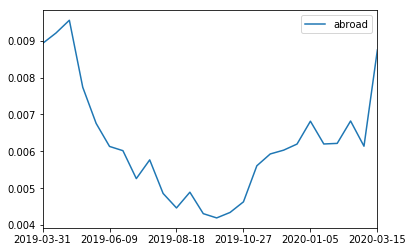

In [71]:
df3.transpose().plot()

In [341]:
ldaseq.print_topic_times(topic=22)[25] # evolution of topic


[('industry', 0.08990630854035118),
 ('house', 0.031934815459293636),
 ('using', 0.03157260735508145),
 ('toronto', 0.029297783151141666),
 ('insurance', 0.02297819731297858),
 ('canada', 0.02028323874839747),
 ('north', 0.01946992657302136),
 ('fight', 0.01935023056670766),
 ('includes', 0.018384762571059487),
 ('freedom', 0.016517653776021095),
 ('update', 0.013876691123466357),
 ('insurers', 0.013207217805399074),
 ('extreme', 0.011226735948546266),
 ('morning', 0.011047360879265302),
 ('fyi', 0.010704662120936105),
 ('bullshit', 0.01054788991953544),
 ('costs', 0.009858563831792263),
 ('ready', 0.009656048746921867),
 ('eliminating', 0.009367471835318062),
 ('products', 0.009249771525197896)]

In [104]:
# Document topic distribution
Doc_topic_matrix=dict()
for doc_num in range(len(my_df)):
    Doc_topic_matrix["doc"+str(doc_num)]=list(ldaseq.doc_topics(doc_num))

In [109]:
col_names =  ['topic'+str(i) for i in range(36)]
Doc_topic_matrix = pd.DataFrame(Doc_topic_matrix,index=col_names)
Doc_topic_matrix = Doc_topic_matrix.transpose()


In [110]:
Doc_topic_matrix

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic26,topic27,topic28,topic29,topic30,topic31,topic32,topic33,topic34,topic35
doc0,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.295630,0.001572,...,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572,0.001572
doc1,0.069568,0.000696,0.000696,0.000696,0.085431,0.000696,0.000696,0.000696,0.000696,0.000696,...,0.084698,0.000696,0.000696,0.000696,0.000696,0.166011,0.000696,0.090988,0.000696,0.120690
doc2,0.066118,0.000651,0.000651,0.000651,0.000651,0.000651,0.336174,0.000651,0.000651,0.070457,...,0.000651,0.000651,0.000651,0.000651,0.066077,0.000651,0.000651,0.081175,0.097644,0.000651
doc3,0.000428,0.000428,0.000428,0.000428,0.000428,0.000428,0.081542,0.000428,0.000428,0.000428,...,0.000428,0.000428,0.060431,0.209550,0.000428,0.000428,0.043553,0.053354,0.000428,0.000428
doc4,0.000517,0.104257,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,...,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.000517,0.062812
doc5,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.000300,0.030924,0.000300,0.000300,...,0.000300,0.112752,0.066768,0.112923,0.000300,0.000300,0.000300,0.297741,0.000300,0.000300
doc6,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,...,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809
doc7,0.041644,0.000411,0.000411,0.000411,0.043421,0.000411,0.000411,0.000411,0.000411,0.000411,...,0.000411,0.000411,0.454484,0.000411,0.000411,0.000411,0.000411,0.000411,0.000411,0.066695
doc8,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809,...,0.081705,0.000809,0.000809,0.611400,0.000809,0.000809,0.000809,0.000809,0.000809,0.000809
doc9,0.000411,0.000411,0.000411,0.000411,0.000411,0.086580,0.044071,0.000411,0.000411,0.042945,...,0.000411,0.000411,0.000411,0.000411,0.041683,0.000411,0.000411,0.000411,0.589175,0.044850


In [37]:
Doc_topic_matrix.to_pickle("./Doc_topic_matrix.pkl")

In [81]:
Doc_topic_matrix = pd.read_pickle("./Doc_topic_matrix.pkl")

In [128]:
# Most representative doc of a given topic
topic_num = 17
Doc_topic_matrix[Doc_topic_matrix['topic'+str(topic_num)]==Doc_topic_matrix['topic'+str(topic_num)].max()]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic26,topic27,topic28,topic29,topic30,topic31,topic32,topic33,topic34,topic35
doc7969,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,...,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394,0.000394


In [135]:
my_df['tweet'][174]

"Contraception is generally not covered by publicly funded health care in Canada. It's a prescription, and those are covered by private insurance."

In [115]:
Doc_topic_matrix[Doc_topic_matrix['topic19']==Doc_topic_matrix['topic19'].max()]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic26,topic27,topic28,topic29,topic30,topic31,topic32,topic33,topic34,topic35
doc12564,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,...,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196,0.001196


In [304]:
[sentence  for sentence in set(list(my_df["tweet"])) if 'universal' in sentence]


['I think if she could just ease up on eliminating private insurance....it would help a great deal. Many countries with universal healthcare (like Canada), private insurance mostly through employers...still plays a role. ',
 'If you’re implying that we convert to a government paid health insurance plan, you are out of your mind. Canada has one of the longest hospital wait times BECAUSE of its universal health care. The taxes are higher on citizens to continue the government funding of hospitals.',
 'In Canada ALL kids go to college affordably. 85% of Canadians are college educated. We hire immigrants and refugees to work at McDonald’s for $14/hour. We have universal healthcare and prescriptions and get great capital gains investing in American health insurance companies.',
 'You know only UK and Canada have a M4A type system. Most countries have universal systems that insure all w/o it being completely under government control. They do however have huge controls on healthcare delivery 

In [173]:
Doc_topic_matrix_by_time= dict()
pos=0
ind=0
for num in time_slice:
    Doc_topic_matrix_by_time["corpus"+str(ind)]=Doc_topic_matrix[pos:pos+num]
    pos= pos+num
    ind=ind+1

    

In [335]:
# Most representative doc of a given topic by fortnight

topic_num = 3
time_stamp=19
Doc_topic_matrix_by_time["corpus"+str(time_stamp)][Doc_topic_matrix_by_time["corpus"+str(time_stamp)]['topic'+str(topic_num)]==Doc_topic_matrix_by_time["corpus"+str(time_stamp)]['topic'+str(topic_num)].max()]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic26,topic27,topic28,topic29,topic30,topic31,topic32,topic33,topic34,topic35
doc28823,0.000468,0.000468,0.000468,0.425416,0.000468,0.000468,0.000468,0.000468,0.000468,0.000468,...,0.000468,0.000468,0.000468,0.124862,0.000468,0.000468,0.000468,0.132634,0.000468,0.000468


In [336]:
my_df['tweet'][28823]

'Average out-of-pocket spending for a day in the hospital US: $1,013 (w/insurance) Austria: $22 France: $22 Germany: $11 Sweden: $11 Estonia: $2 Norway: $0 Denmark: $0 Canada: $0 Italy: $0 United Kingdom: $0 Portugal: $0 Spain: $0 Israel: $0 Iceland: $0 Poland: $0 Austria: $0 '

In [187]:
df= pd.DataFrame()
for key in Doc_topic_matrix_by_time:
#     print(len(pd.DataFrame(dic[key].mean())))
#     df[key]= list(pd.DataFrame(dic[key].mean()))
    df = pd.concat([df, pd.DataFrame(Doc_topic_matrix_by_time[key].mean())], axis=1)
df.columns =dates


In [188]:
df.sum()

2019-03-31    1.0
2019-04-14    1.0
2019-04-28    1.0
2019-05-12    1.0
2019-05-26    1.0
2019-06-09    1.0
2019-06-24    1.0
2019-07-07    1.0
2019-07-21    1.0
2019-08-04    1.0
2019-08-18    1.0
2019-09-01    1.0
2019-09-15    1.0
2019-09-29    1.0
2019-10-13    1.0
2019-10-27    1.0
2019-11-10    1.0
2019-11-24    1.0
2019-12-08    1.0
2019-12-22    1.0
2020-01-05    1.0
2020-01-19    1.0
2020-02-02    1.0
2020-02-16    1.0
2020-03-01    1.0
2020-03-15    1.0
dtype: float64

In [193]:
df["max"] = df.max(axis=1)

In [305]:
df

,2019-03-31,2019-04-14,2019-04-28,2019-05-12,2019-05-26,2019-06-09,2019-06-24,2019-07-07,2019-07-21,2019-08-04,...,2019-11-24,2019-12-08,2019-12-22,2020-01-05,2020-01-19,2020-02-02,2020-02-16,2020-03-01,2020-03-15,max
topic0,0.011620,0.017406,0.015693,0.013140,0.017171,0.013256,0.011904,0.013163,0.010417,0.010777,...,0.013668,0.014195,0.013380,0.013736,0.014585,0.012466,0.011019,0.011487,0.015481,0.017406
topic1,0.040308,0.044795,0.049981,0.063345,0.064098,0.068295,0.040497,0.051611,0.039403,0.044206,...,0.063232,0.050474,0.049456,0.052225,0.056984,0.042277,0.029773,0.031470,0.052877,0.068295
topic2,0.012247,0.019408,0.013175,0.009904,0.010026,0.011740,0.008903,0.009444,0.009472,0.009980,...,0.009206,0.010469,0.008805,0.008340,0.009782,0.009005,0.009123,0.009520,0.010494,0.019408
topic3,0.016887,0.016109,0.013554,0.014240,0.014213,0.013614,0.014853,0.014504,0.014906,0.010965,...,0.014899,0.017902,0.018495,0.018025,0.012758,0.014459,0.016028,0.017054,0.013223,0.029009
topic4,0.015270,0.010192,0.013650,0.011812,0.013263,0.015641,0.011419,0.012626,0.012703,0.013453,...,0.018658,0.017817,0.017822,0.027106,0.049006,0.049339,0.063232,0.051742,0.036368,0.063232
topic5,0.042468,0.048243,0.047770,0.032832,0.032388,0.038472,0.027531,0.027839,0.033423,0.060194,...,0.044368,0.030493,0.025601,0.034619,0.041756,0.030249,0.034040,0.022754,0.022770,0.060194
topic6,0.023105,0.016342,0.012995,0.010653,0.013583,0.014268,0.011384,0.011415,0.011040,0.011009,...,0.014031,0.016096,0.025199,0.019221,0.020588,0.013380,0.011692,0.013925,0.016166,0.025199
topic7,0.012215,0.009958,0.011891,0.014204,0.010254,0.011654,0.010723,0.010470,0.015545,0.018155,...,0.013011,0.012632,0.011362,0.011137,0.010816,0.011929,0.011055,0.011090,0.008912,0.018155
topic8,0.023684,0.023042,0.024302,0.029050,0.023791,0.029564,0.021209,0.020000,0.020170,0.017510,...,0.018977,0.026961,0.019933,0.021268,0.021700,0.025046,0.022152,0.034518,0.070431,0.070431
topic9,0.011439,0.010979,0.012358,0.011892,0.012758,0.013742,0.010454,0.014040,0.008276,0.011430,...,0.010997,0.008819,0.008211,0.008760,0.010216,0.008416,0.007456,0.007916,0.010410,0.017193


In [195]:
df2=df['max']<0.04

In [196]:
first = df[df2]
second = df[-df2]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(array([ 0.,  5., 10., 15., 20., 25.]), <a list of 6 Text xticklabel objects>)

<Figure size 576x432 with 0 Axes>

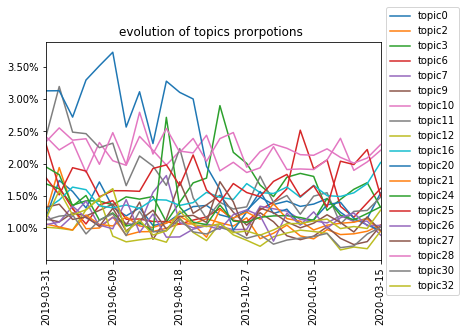

In [206]:
from matplotlib.ticker import PercentFormatter

figure = plt.gcf() # get current figure
figure.set_size_inches(8, 6)

first.iloc[:,:-1].transpose().plot(title="evolution of topics prorpotions ")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)

